# Use single column output to simulate lidar output
## See whether a normalized height grid will yield higher-order moments closer to the slab values than a regular height grid

Import relevant packages

In [39]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
import seaborn as sns
from scipy import stats
from tabulate import tabulate
from matplotlib.ticker import AutoMinorLocator

data starts at 8 GMT, which is 3 CDT, so 0 in the data is 3 CDT

In [40]:
dir = '/data/lafe/20170808_col/throughevening/'
date = '20170808'

In [41]:
# define the time period
local_start =5  # the start time locally
local_end = 22 # the end time locally
colx = 4 # 0-7 which column number
coly = 4 # 0-7 which column number

In [42]:
t0 = local_start -3 # start hour in the data
t1 = local_end -3 # end hour in the data
noon = 9*3600 # the noon hour in the data
adj = local_start - t0 # the difference between the time in the data and local time
start = t0*3600 # start time in seconds
end = t1*3600 # end time in seconds
one_window = 360 #window 60 min
ksurf = 3 # surface layer
order = 3
window_list = np.arange(4,360,3) # the averaging window for the flux calculations
cp = 1.004
Lv = 2.5e3

In [43]:
# define the x and y locations of the columns - based on the ini file
x_file=[0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560,0,80,160,240,320,400,480,560]
y_file=[0,0,0,0,0,0,0,0,80,80,80,80,80,80,80,80,160,160,160,160,160,160,160,160,240,240,240,240,240,240,240,240,320,320,320,320,320,320,320,320,400,400,400,400,400,400,400,400,480,480,480,480,480,480,480,480,560,560,560,560,560,560,560,560]


In [44]:
# loop through to get the filenames
filenames = np.empty(len(x_file),dtype=object)
for i in range(len(x_file)):
    filenames[i] ='testbed.column.'+str(format(int(y_file[i]),'05d'))+'.'+str(format(int(x_file[i]),'05d'))+'.0000000.nc'


prof_all = xr.open_dataset(dir + 'merged_prof_from_all_columns.nc', decode_times=False)
time = prof_all['time']
time = xr.DataArray(time, coords={'time':time}, dims=['time'])
dt = time.diff('time')[0].to_numpy()
z = prof_all['z']
zh = prof_all['zh']


In [45]:
# Function Definitions
def lnb(pot_temp,time_thing): # level of neutral buoyancy BL definition (thl)
    delta = 0.5*cp
    ki = (pot_temp>delta+np.tile(pot_temp[:,:1],[1,pot_temp.shape[1]])).argmax(axis=1)#.to_numpy()
    lim = np.where(time_thing.astype(int)==60899)[0][0]
    for i in range(time_thing.size):
        if i <=  lim and abs(ki[i] - ki[i-1]) > 50:
            ki[i] = ki[i-1]
    return ki


def flux(property, w, window): # flux calculations = (a property (x) - average of property (y)) * (w - w_average (z))
    time = prof_all['time']
    z = prof_all['z']
    property_avg = uniform_filter1d(property, size = window, axis = 0)
    w_avg = uniform_filter1d(w, size = window, axis = 0)
    fluxes = uniform_filter1d((property - property_avg) * (w - w_avg), size=window, axis = 0)
    return xr.DataArray(fluxes, coords={'time':time,'z':z}, dims=['time','z'])


def variance(property, window):
    property_avg = uniform_filter1d(property, size=window, axis=0)
    sqrdf = (property - property_avg)**2
    sum_squared_diff  = uniform_filter1d(sqrdf, size=window, axis=0)
    num_elements = uniform_filter1d(np.ones_like(property), size=window, axis=0)
    var = sum_squared_diff / num_elements
    if type(var) == xr.DataArray:
        result = xr.DataArray(var, dims=property.dims, coords=property.coords)
    else:
        result = var
    return result

def stdev(property, window):
    var = variance(property, window)
    std_dev = np.sqrt(var)
    return std_dev

def skewness(property, window):
    property_avg = uniform_filter1d(property, size=window, axis=0)
    deviations = property - property_avg
    std_deviation = stdev(property, window)
    skew = uniform_filter1d((deviations / std_deviation)**3, size=window, axis=0)
    if type(skew) == xr.DataArray:
        result = xr.DataArray(skew, dims=property.dims, coords=property.coords)
    else:
        result = skew
    return result

def kurtosis(property, window):
    property_avg = uniform_filter1d(property, size=window, axis=0)
    deviations = property - property_avg
    std_deviation = stdev(property, window)
    kurt = uniform_filter1d((deviations / std_deviation)**4, size=window, axis=0)
    if type(kurt) == xr.DataArray:
        result = xr.DataArray(kurt, dims=property.dims, coords=property.coords)
    else:
        result = kurt
    return result

In [46]:
# single column wind speeds
u = prof_all['u'][colx,coly,:,:]
v = prof_all['v'][colx,coly,:,:]
wh = prof_all['w'][colx,coly,:,:] #w velocity defined at zh
w = wh.interp(time = time, zh = z) #take the vertical velocity at z instead of zh


In [47]:
# GET SLAB VARIABLES
filenames_slab = 'testbed.default.0000000.nc'
groups_slab = [''] + list(nc.Dataset(dir + filenames_slab).groups.keys())
prof_dict_slab = {}
for group in groups_slab:
    prof_dict_slab[group] = xr.open_dataset(dir + filenames_slab, group=group, decode_times=False)
prof_slab = xr.merge(prof_dict_slab.values(), compat = 'override')

time_slab = prof_slab['time']
dt_slab = time_slab.diff('time')[0].to_numpy()
sr_slab = int((abs(time_slab - start)).argmin())
ss_slab = int((abs(time_slab - end)).argmin())
rho = prof_slab['rho']
rhoh = prof_slab['rhoh']
corr = rho/rho[0,0]
corrh = rhoh/rhoh[0,0]
z = prof_slab['z']
zh = prof_slab['zh']

In [48]:
thl = prof_all['thl'][colx,coly,:,:] #single column potential temperature
qt = prof_all['qt'][colx,coly,:,:]*1000 #single column water vapor mixing ratio
thl_slab = prof_slab['thl']

In [49]:
# calculate boundary layer depths from a single column and from the slab
kiK = lnb(thl,time)
kiK_slab = lnb(thl_slab,time_slab)
ziK = zh[kiK]
ziK_slab = zh[kiK_slab]
kiKsmooth = np.round(savgol_filter(kiK, one_window, order))
kiKsmooth = np.maximum(kiKsmooth, 0).astype(int)
kiKsmooth = xr.DataArray(kiKsmooth, coords={'time':time}, dims=['time'])
zismooth = zh[kiKsmooth]

In [50]:
#RMSE of the ziK_slab and zismooth
rmse = np.sqrt(np.mean((zismooth - ziK_slab)**2))

Plot the unsmoothed single column boundary layer depth, the smoothed single column boundary layer depth, and the slab boundary layer depth

/tmp/ipykernel_368778/1552312029.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/1552312029.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)


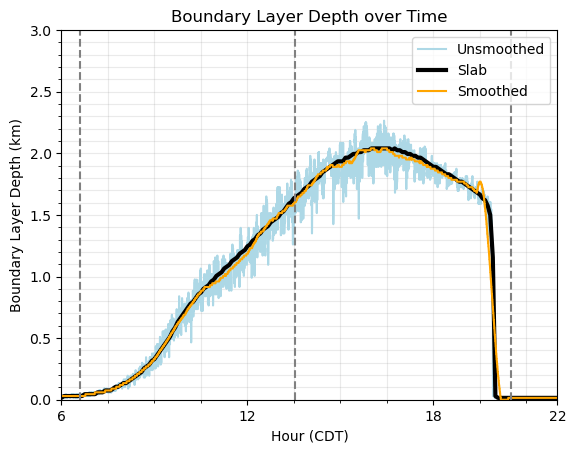

In [51]:
plt.plot((time/3600)+3,ziK/1000, label = 'Unsmoothed', color = 'lightblue')
plt.plot((time_slab/3600)+3,ziK_slab/1000, label = 'Slab', color = 'black',linewidth = 3)
plt.plot((time/3600)+3,zismooth/1000, label = 'Smoothed', color = 'orange')
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
# Set minor ticks at each whole number
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Boundary Layer Depth (km)')
plt.title('Boundary Layer Depth over Time')
plt.legend()

In [52]:
# get the slab fluxes, variance, skewness, and kurtosis
qt_var =prof_slab['qt_2']*(1000**2) 
thl_var = prof_slab['thl_2']
thl_skew = prof_slab['thl_3']/(prof_slab['thl_2']**(3/2))
qt_skew = prof_slab['qt_3']/(prof_slab['qt_2']**(3/2))
thlflux = prof_slab['thl_flux']
qtflux = prof_slab['qt_flux']*(1000)
w_var = prof_slab['w_2'].interp(time = time_slab, zh = z)
w_skew = (prof_slab['w_3'].interp(time=time_slab,zh=z))/((prof_slab['w_2'].interp(time = time_slab, zh=z))**(3/2))
thl_kurt = prof_slab['thl_4']/(prof_slab['thl_2']**2)
qt_kurt = prof_slab['qt_4']/(prof_slab['qt_2']**2)
w_kurt = prof_slab['w_4'].interp(time = time_slab, zh = z)/(prof_slab['w_2'].interp(time = time_slab, zh = z)**2)


In [53]:
# Get the colormap and create a mask over 1.2 the boundary layer depth
cmap = plt.get_cmap('jet')
time_slab = (time_slab/3600)+3
z = z/1000
time_mesh, z_mesh = np.meshgrid(time_slab[::6], z)
numlevels = 100
zi_2d = np.tile(ziK_slab[::6]/1000, (len(z), 1))
mask = z_mesh > (1.2 * zi_2d)

timezhmesh, zh_mesh = np.meshgrid(time_slab[::6], zh/1000)
zhzi = zh[kiK_slab]/1000
zhi_2d = np.tile(zhzi[::6], (len(zh), 1))
maskzh = zh_mesh > (1.2 * zhi_2d)

In [54]:
# define vmin and vmax for the different figures to keep the colorbars consistent
thlfluxvmin =-0.2
thlfluxvmax = 0.5
qtfluxvmin = -0.72
qtfluxvmax = 0.6
thlvarvmin = 0
thlvarvmax = 1.215
qtvarvmin = 0
qtvarvmax = 2.97
thlskewvmin = -4
thlskewvmax = 4
qtskewvmin = -3
qtskewvmax = 3


Now, we are going to calculate the fluxes, variance, skewness, and kurtosis for a single column using a regular height grid

In [55]:
thl_varreg = variance(thl, one_window)
qt_varreg = variance(qt, one_window)
thl_skewreg = skewness(thl, one_window)
qt_skewreg = skewness(qt, one_window)
thl_fluxreg = flux(thl, w, one_window)
qt_fluxreg = flux(qt, w, one_window)
w_varreg = variance(w, one_window)
w_skewreg = skewness(w, one_window)
thl_kurtreg = kurtosis(thl, one_window)
qt_kurtreg = kurtosis(qt, one_window)
w_kurtreg = kurtosis(w, one_window)

# again, create the mask
time_mesh, z_mesh = np.meshgrid(time[::180]/3600+3, z)
zism = zismooth/1000
zi_2d = np.tile(zismooth[::180]/1000, (len(z), 1))
mask = z_mesh > (1.2 * zi_2d)

Now, we are going to normalize the variables by shifting them onto a normalized height grid

In [56]:
z_da = xr.DataArray(z, dims='z')
zism_da = xr.DataArray(zism, dims='time')
znorm = z_da / zism_da
znorm = znorm.T
qt_norm = np.empty((time.size, z.size))
thl_norm = np.empty((time.size, z.size))
w_norm = np.empty((time.size, z.size))
for i in range(time.size):
    qt_norm[i,:] = np.interp(z, znorm[i,:], qt[i,:])
    thl_norm[i,:] = np.interp(z, znorm[i,:], thl[i,:])
    w_norm[i,:] = np.interp(z, znorm[i,:], w[i,:])

Calculate the fluxes, variance, skewness, and kurtosis from the normalized height grid

In [57]:
thl_varnormnorm = variance(thl_norm, one_window)
qt_varnormnorm = variance(qt_norm, one_window)
thl_skewnormnorm = skewness(thl_norm, one_window)
qt_skewnormnorm = skewness(qt_norm, one_window)
thl_flunormnorm = flux(thl_norm, w_norm, one_window)
qt_flunormnorm = flux(qt_norm, w_norm, one_window)
w_varnormnorm = variance(w_norm, one_window)
w_skewnormnorm = skewness(w_norm, one_window)
thl_kurtnormnorm = kurtosis(thl_norm, one_window)
qt_kurtnormnorm = kurtosis(qt_norm, one_window)
w_kurtnormnorm = kurtosis(w_norm, one_window)


Interpolate the normalized variables back onto the regular height grid 

In [58]:
thl_varnorm = np.empty((time.size, z.size))
qt_varnorm = np.empty((time.size, z.size))
thl_skewnorm = np.empty((time.size, z.size))
qt_skewnorm = np.empty((time.size, z.size))
thl_fluxnorm = np.empty((time.size, z.size))
qt_fluxnorm = np.empty((time.size, z.size))
w_varnorm = np.empty((time.size, z.size))
w_skewnorm = np.empty((time.size, z.size))
thl_kurtnorm = np.empty((time.size, z.size))
qt_kurtnorm = np.empty((time.size, z.size))
w_kurtnorm = np.empty((time.size, z.size))
for i in range(time.size):
    thl_varnorm[i,:] = np.interp(znorm[i,:],z, thl_varnormnorm[i,:])
    qt_varnorm[i,:] = np.interp(znorm[i,:],z, qt_varnormnorm[i,:])
    thl_skewnorm[i,:] = np.interp( znorm[i,:], z,thl_skewnormnorm[i,:])
    qt_skewnorm[i,:] = np.interp(znorm[i,:],z, qt_skewnormnorm[i,:])
    thl_fluxnorm[i,:] = np.interp(znorm[i,:],z, thl_flunormnorm[i,:])
    qt_fluxnorm[i,:] = np.interp(znorm[i,:],z, qt_flunormnorm[i,:])
    w_varnorm[i,:] = np.interp(znorm[i,:],z, w_varnormnorm[i,:])
    w_skewnorm[i,:] = np.interp(znorm[i,:],z, w_skewnormnorm[i,:])
    thl_kurtnorm[i,:] = np.interp(znorm[i,:],z, thl_kurtnormnorm[i,:])
    qt_kurtnorm[i,:] = np.interp(znorm[i,:],z, qt_kurtnormnorm[i,:])
    w_kurtnorm[i,:] = np.interp(znorm[i,:],z, w_kurtnormnorm[i,:])

Compare the fluxes by a side-by-side of the slab, regular, and normalized, and then by looking at the difference between the slab and the regular and normalized respectively

Text(3, -0.35, 'b)')

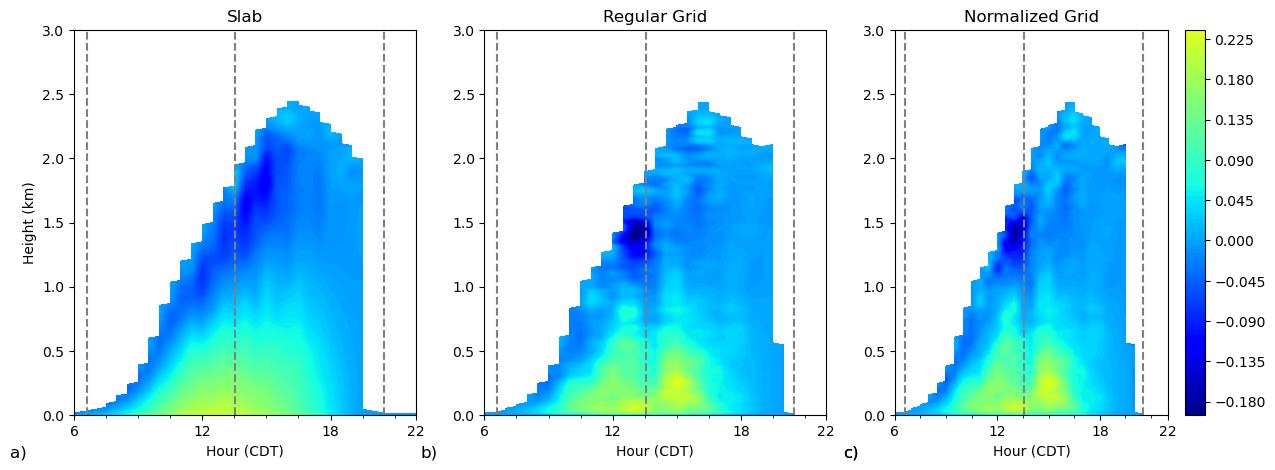

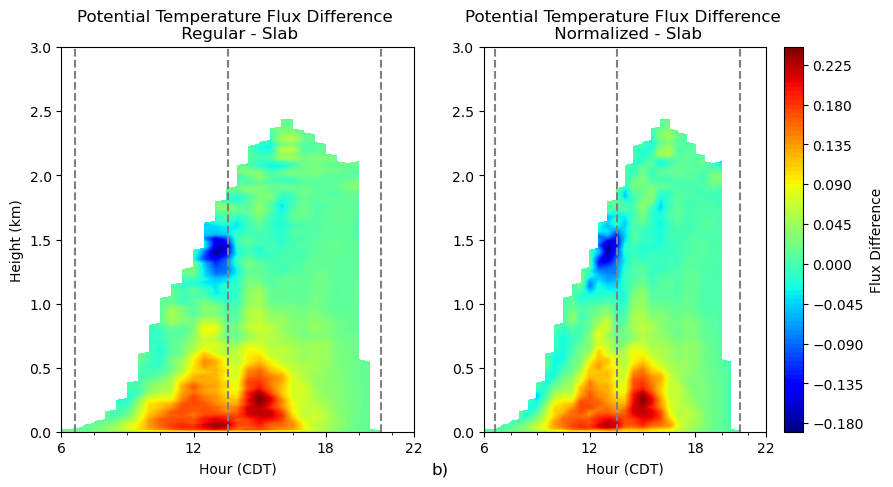

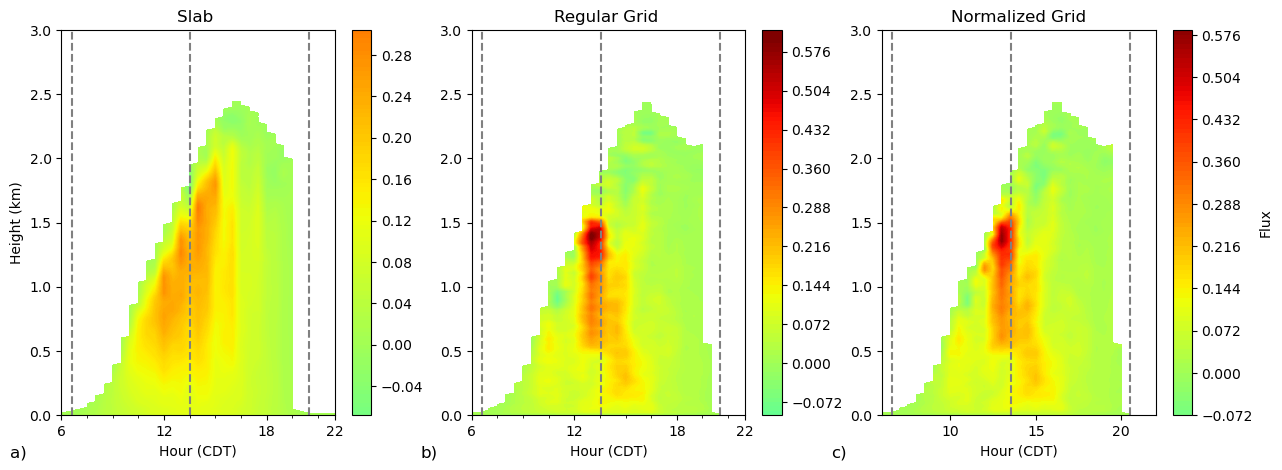

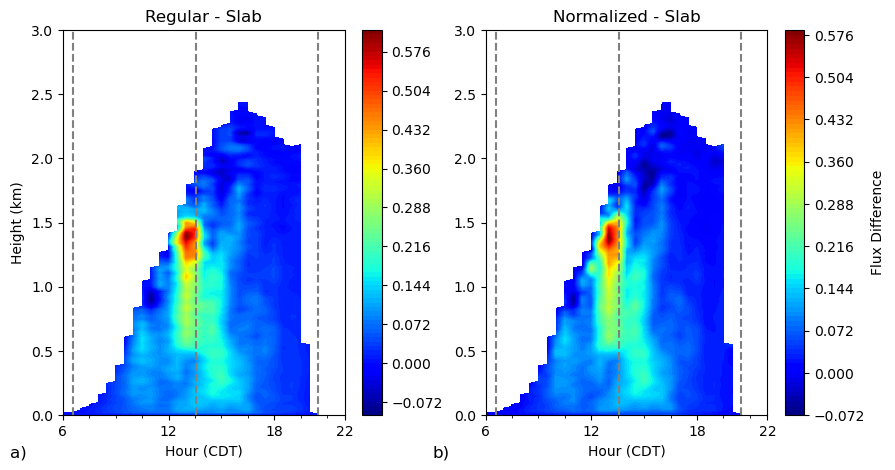

In [59]:
thlfluxz = thlflux.interp(time = time_slab, zh = z)
qtfluxz = qtflux.interp(time = time_slab, zh = z)
thl_fluxdiff = thl_fluxreg[::180,:] - thlfluxz[::6,:] 
qt_fluxdiff = qt_fluxreg[::180,:] - qtfluxz[::6,:]
thl_fluxdiffnorm = thl_fluxnorm[::180,:] -thlfluxz[::6,:] 
qt_fluxdiffnorm = qt_fluxnorm[::180,:] - qtfluxz[::6,:]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(timezhmesh, zh_mesh, np.ma.masked_where(maskzh, thlflux[::6,:].T), vmin = thlfluxvmin, vmax = thlfluxvmax ,cmap=cmap, levels=numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh, z_mesh, np.ma.masked_where(mask, thl_fluxreg[::180,:].T),vmin = thlfluxvmin, vmax = thlfluxvmax ,cmap=cmap, levels=numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,thl_fluxnorm[::180,:].T),vmin = thlfluxvmin, vmax = thlfluxvmax ,cmap=cmap, levels=numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_fluxdiff.T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Potential Temperature Flux Difference \n Regular - Slab')
plt.subplot(1,2,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_fluxdiffnorm.T), cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Flux Difference')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Potential Temperature Flux Difference \n Normalized - Slab')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(timezhmesh, zh_mesh, np.ma.masked_where(maskzh, qtflux[::6,:].T), vmin = qtfluxvmin, vmax = qtfluxvmax,cmap = cmap,levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab ')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,qt_fluxreg[::180,:].T), vmin = qtfluxvmin, vmax = qtfluxvmax,cmap = cmap,levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid ')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,qt_fluxnorm[::180,:].T), vmin = qtfluxvmin, vmax = qtfluxvmax,cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Flux')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_fluxdiff.T), cmap = cmap,levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Regular - Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,2,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_fluxdiffnorm.T), cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Flux Difference')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized - Slab')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


Compare the variance by a side-by-side of the slab, regular, and normalized, and then by looking at the difference between the slab and the regular and normalized respectively

Text(3, -0.35, 'b)')

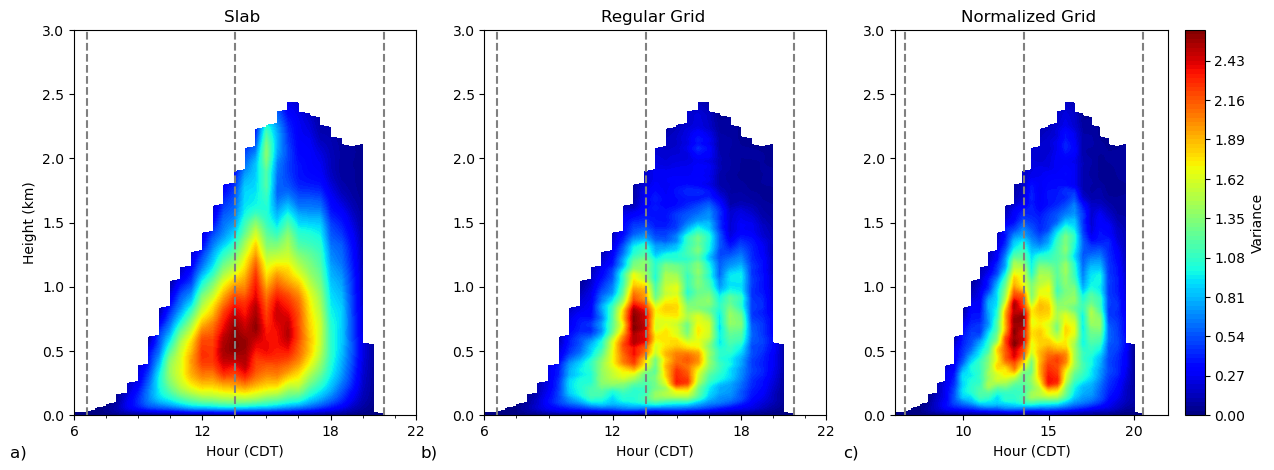

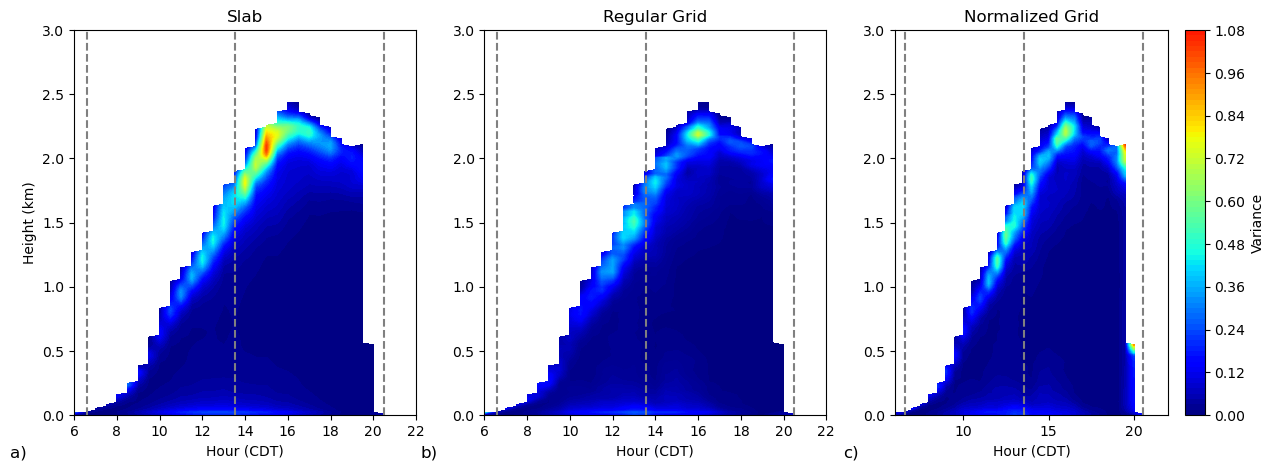

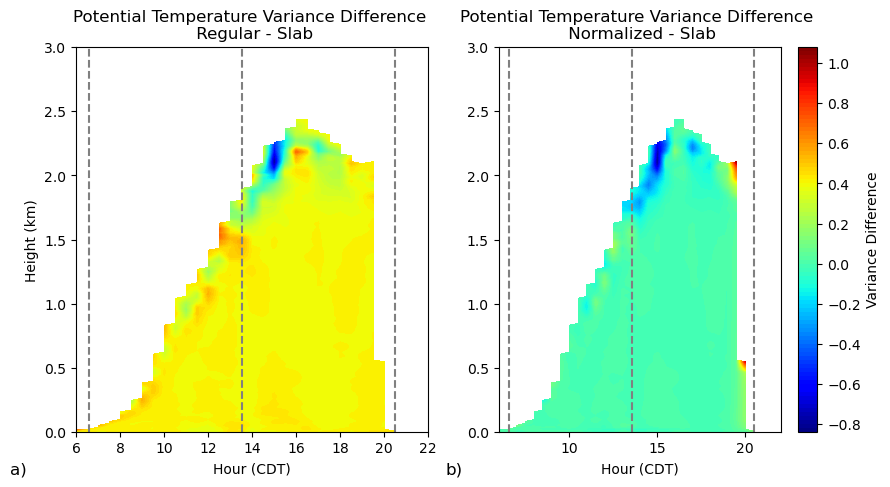

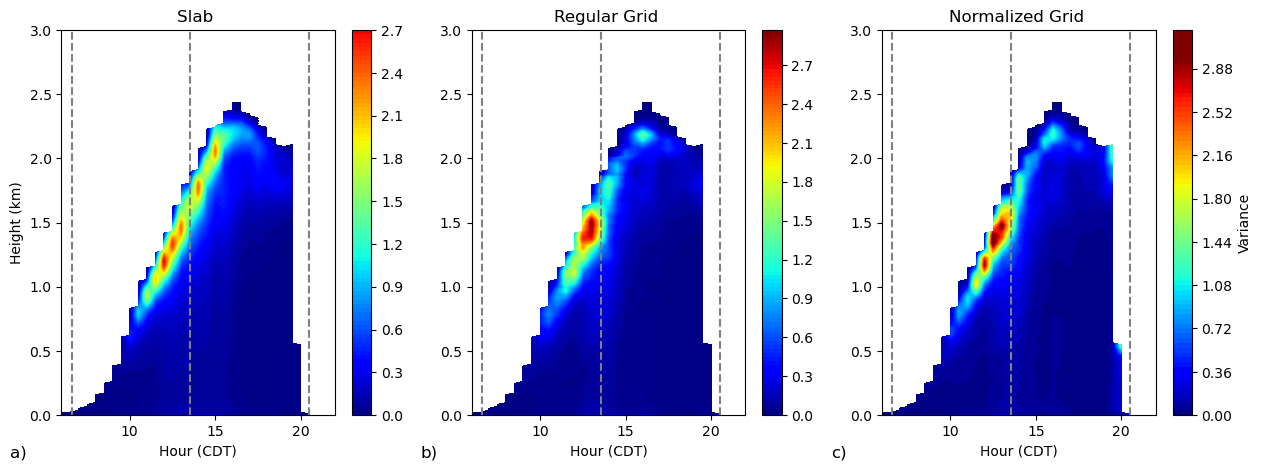

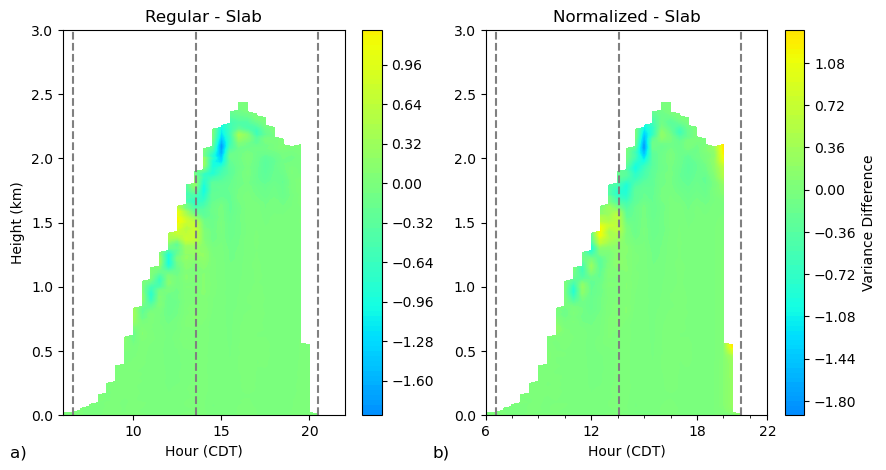

In [60]:
thl_vardiffreg = thl_varreg[::180,:]  - thl_var[::6,:]
qt_vardiffreg = qt_varreg[::180,:] - qt_var[::6,:]
thl_skewdiffreg = thl_skewreg[::180,:] - thl_skew[::6,:]
qt_skewdiffreg = qt_skewreg[::180,:] - qt_skew[::6,:]


thl_vardiffnorm = thl_varnorm[::180,:] - thl_var[::6,:]
qt_vardiffnorm =qt_varnorm[::180,:] - qt_var[::6,:]
thl_skewdiffnorm =  thl_skewnorm[::180,:] - thl_skew[::6,:]
qt_skewdiffnorm = qt_skewnorm[::180,:] - qt_skew[::6,:]


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh, z_mesh, np.ma.masked_where(mask, w_var[::6,:].T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab ')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,w_varreg[::180,:].T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid ')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,w_varnorm[::180,:].T), cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Variance')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid ')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_var[::6,:].T), vmin = thlvarvmin, vmax = thlvarvmax ,cmap=cmap, levels=numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_varreg[::180,:].T),  vmin = thlvarvmin, vmax = thlvarvmax ,cmap=cmap, levels=numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_varnorm[::180,:].T),  vmin = thlvarvmin, vmax = thlvarvmax ,cmap=cmap, levels=numlevels)
plt.colorbar(label = 'Variance')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_vardiffreg.T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Potential Temperature Variance Difference \n Regular - Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,2,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_vardiffnorm.T), cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Variance Difference')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.title('Potential Temperature Variance Difference \n Normalized - Slab')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_var[::6,:].T), vmin = qtvarvmin, vmax = qtvarvmax ,cmap = cmap,levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab ')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_varreg[::180,:].T), vmin = qtvarvmin, vmax = qtvarvmax ,cmap = cmap,levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid ')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_varnorm[::180,:].T), vmin = qtvarvmin, vmax = qtvarvmax ,cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Variance')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid ')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_vardiffreg.T),vmin = -4, vmax = 4, cmap = cmap,levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Regular - Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,2,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_vardiffnorm.T), vmin = -4, vmax=4,cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Variance Difference')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized - Slab')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


Compare skewness

Text(3, -0.35, 'b)')

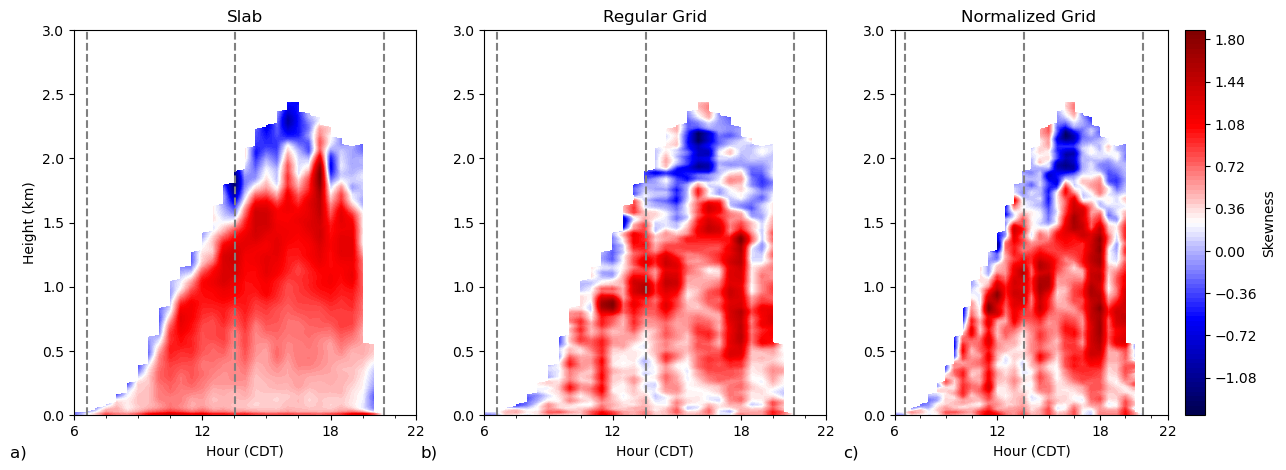

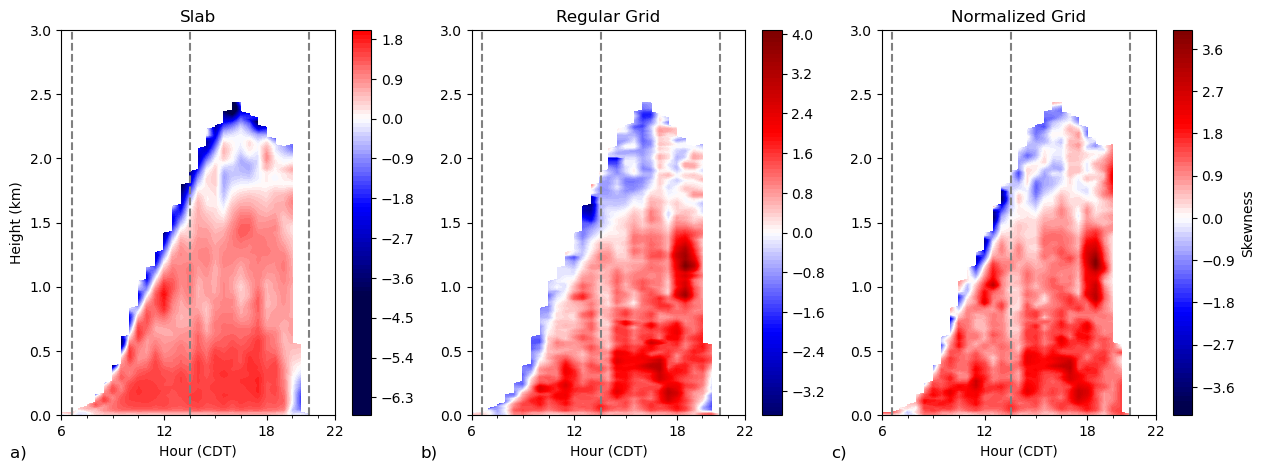

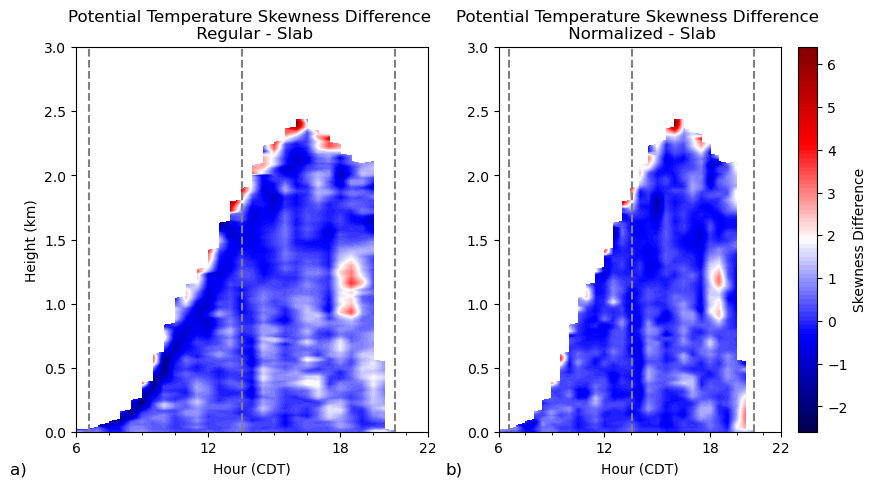

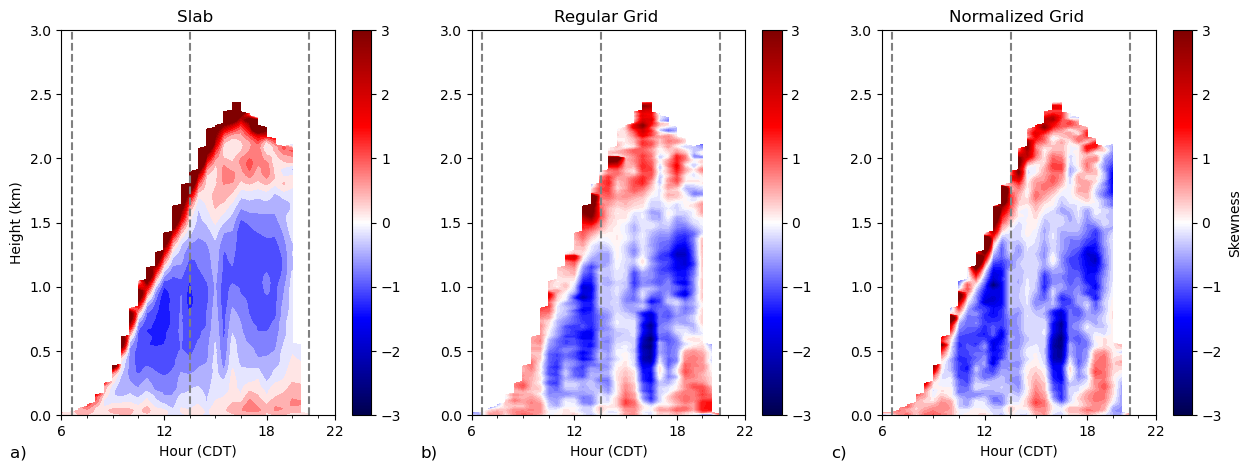

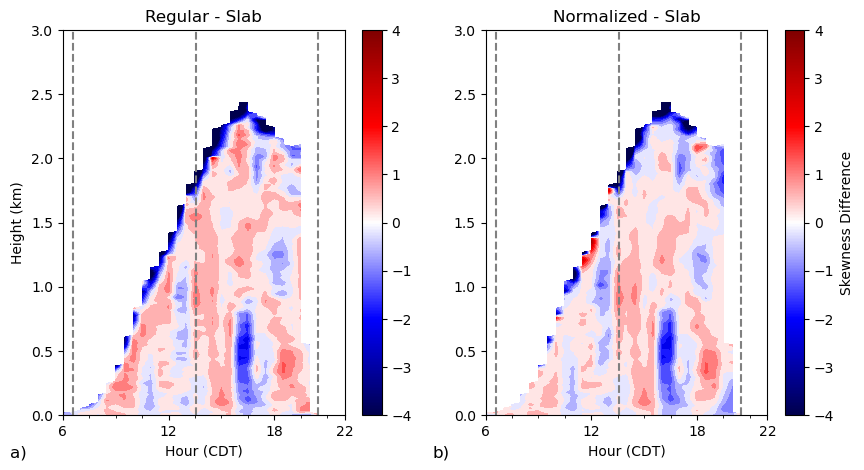

In [61]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh, z_mesh, np.ma.masked_where(mask, w_skew[::6,:].T), cmap = 'seismic',levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,w_skewreg[::180,:].T), cmap = 'seismic',levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,w_skewnorm[::180,:].T), cmap = 'seismic',levels = numlevels)
plt.colorbar(label = 'Skewness')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid ')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_skew[::6,:].T), vmin = thlskewvmin, vmax = thlskewvmax ,cmap = 'seismic',levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_skewreg[::180,:].T), vmin = thlskewvmin, vmax = thlskewvmax ,cmap = 'seismic',levels = numlevels)
plt.colorbar()
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_skewnorm[::180,:].T), vmin = thlskewvmin, vmax = thlskewvmax ,cmap = 'seismic',levels = numlevels)
plt.colorbar(label = 'Skewness')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  




plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_skewdiffreg.T), cmap = 'seismic',levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Potential Temperature Skewness Difference \n Regular - Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,2,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,thl_skewdiffnorm.T), cmap = 'seismic',levels = numlevels)
plt.colorbar(label = 'Skewness Difference')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Potential Temperature Skewness Difference \n Normalized - Slab')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_skew[::6,:].T), vmin = qtskewvmin, vmax = qtskewvmax ,cmap = 'seismic',levels = numlevels)
sm =  plt.cm.ScalarMappable(cmap = 'seismic',norm = plt.Normalize(vmin=qtskewvmin,vmax=qtskewvmax))
plt.colorbar(sm)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab ')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_skewreg[::180,:].T), vmin = qtskewvmin, vmax = qtskewvmax ,cmap = 'seismic',levels = numlevels)
plt.colorbar(sm)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid ')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_skewnorm[::180,:].T), vmin = qtskewvmin, vmax = qtskewvmax ,cmap = 'seismic',levels = numlevels)
plt.colorbar(sm ,label = 'Skewness')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid ')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_skewdiffreg.T), vmin = -4, vmax=4,cmap = 'seismic',levels = numlevels)
sm = plt.cm.ScalarMappable(cmap = 'seismic',norm = plt.Normalize(vmin=-4,vmax=4))
plt.colorbar(sm)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Regular - Slab')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,2,2)
plt.contourf(time_mesh,z_mesh,np.ma.masked_where(mask,qt_skewdiffnorm.T), vmin = -4, vmax=4,cmap = 'seismic',levels = numlevels)
plt.colorbar(sm, label = 'Skewness Difference')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized - Slab')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


Compare Kurtosis

Text(3, -0.35, 'c)')

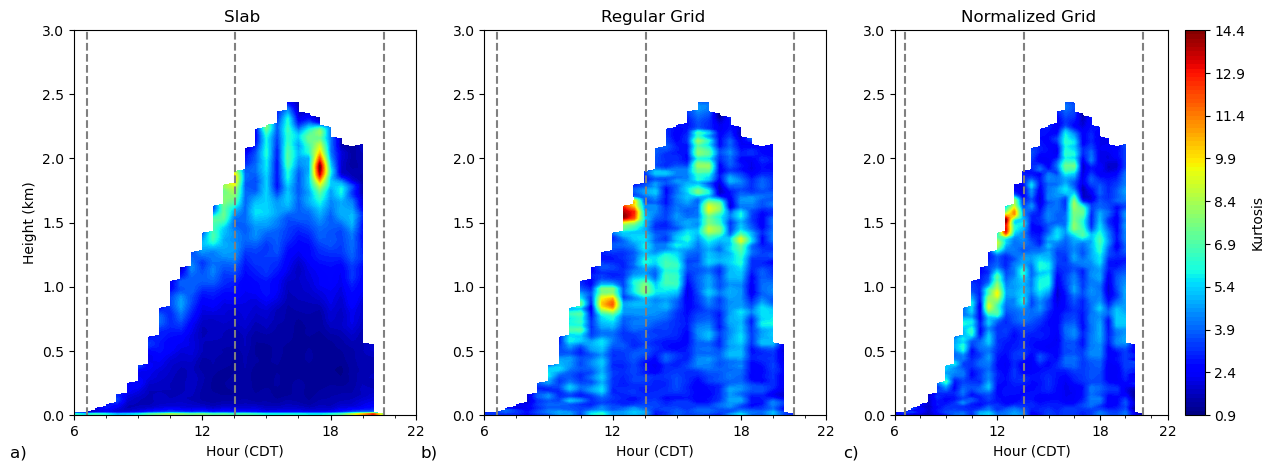

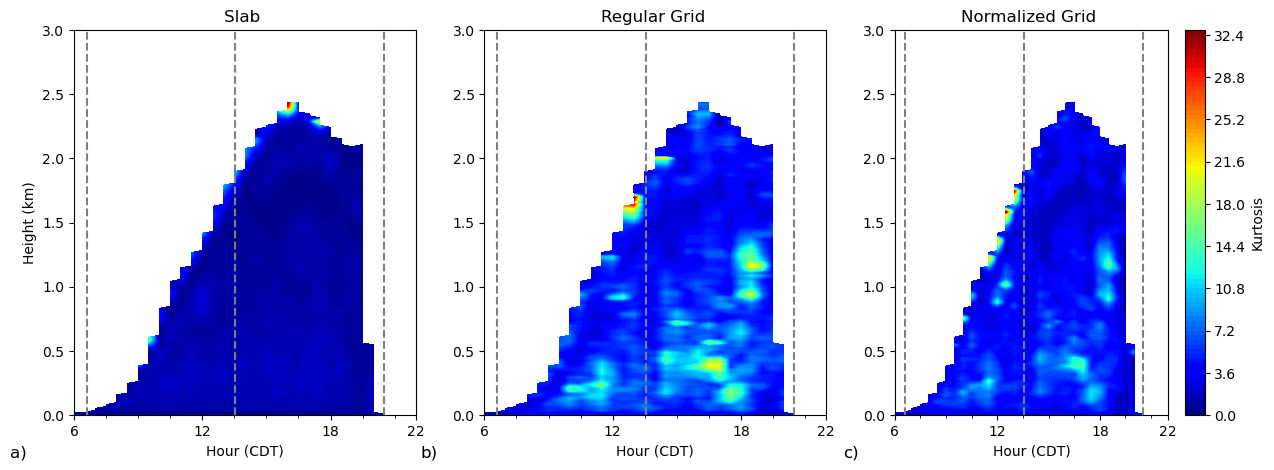

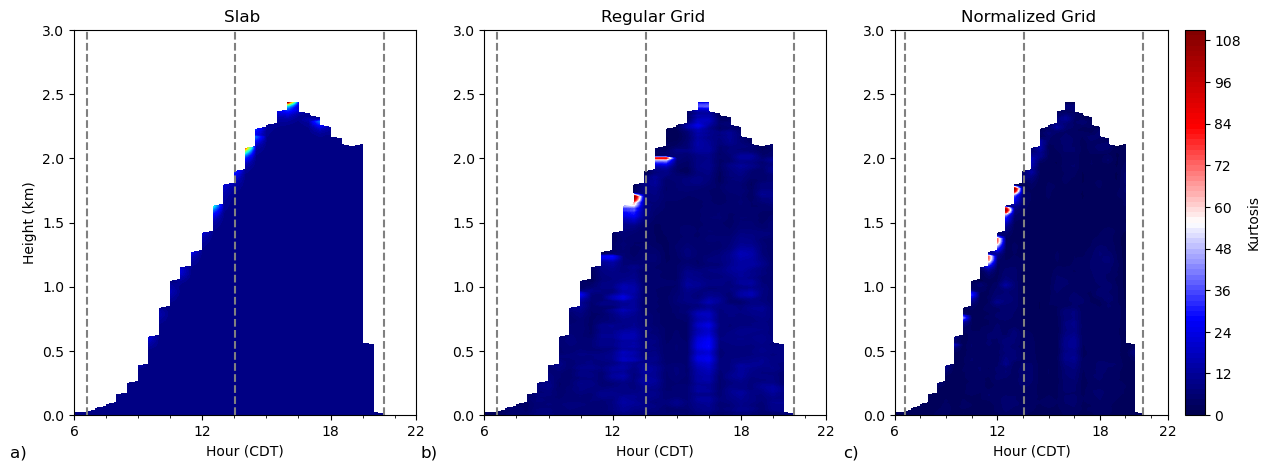

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh, z_mesh, np.ma.masked_where(mask, w_kurt[::6,:].T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab ')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,w_kurtreg[::180,:].T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid ')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,w_kurtnorm[::180,:].T), cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Kurtosis')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid ')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh, z_mesh, np.ma.masked_where(mask, thl_kurt[::6,:].T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab ')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,thl_kurtreg[::180,:].T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid ')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,thl_kurtnorm[::180,:].T), cmap = cmap,levels = numlevels)
plt.colorbar(label = 'Kurtosis')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid ')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.contourf(time_mesh, z_mesh, np.ma.masked_where(mask, qt_kurt[::6,:].T), cmap = cmap,levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Height (km)')
plt.title('Slab ')
plt.text(3, -0.35, 'a)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12) 
plt.subplot(1,3,2)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,qt_kurtreg[::180,:].T), cmap = 'seismic',levels = numlevels)
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Regular Grid ')
plt.text(3, -0.35, 'b)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  
plt.subplot(1,3,3)
plt.contourf(time_mesh,z_mesh, np.ma.masked_where(mask,qt_kurtnorm[::180,:].T), cmap = 'seismic',levels = numlevels)
plt.colorbar(label = 'Kurtosis')
plt.axvline(x=6.6, linestyle='--', color='gray')  # For 6:40am 
plt.axvline(x=13.55, linestyle='--', color='gray')  # For 1:35pm 
plt.axvline(x=20.5, linestyle='--', color='gray')  # For 8:30pm 
plt.xlim(6,22) 
plt.ylim(0,3) 
plt.xticks([6, 12, 18, 22])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.title('Normalized Grid ')
plt.text(3, -0.35, 'c)', verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=12)  


The contour plots are difficult to compare, so we are going to look at line plots at various points in the BL: 75% BL depth, 90% BL depth, and top of the BL

In [63]:
# define the analysis period for the whole day for both a single column and the slab
start = 1080
end = 5760

start_slab = 36
end_slab = 192

time = (time[start:end]/3600)+3
time_slab = time_slab[start_slab:end_slab]

In [64]:
# make everything into an xarray
thl_fluxreg = xr.DataArray(thl_fluxreg, dims=thl.dims, coords=thl.coords)
qt_fluxreg = xr.DataArray(qt_fluxreg, dims=qt.dims, coords=qt.coords)
thl_fluxnorm = xr.DataArray(thl_fluxnorm, dims=thl.dims, coords=thl.coords)
qt_fluxnorm = xr.DataArray(qt_fluxnorm, dims=qt.dims, coords=qt.coords)
thl_varreg = xr.DataArray(thl_varreg, dims=thl.dims, coords=thl.coords)
qt_varreg = xr.DataArray(qt_varreg, dims=qt.dims, coords=qt.coords)
thl_varnorm = xr.DataArray(thl_varnorm, dims=thl.dims, coords=thl.coords)
qt_varnorm = xr.DataArray(qt_varnorm, dims=qt.dims, coords=qt.coords)
thl_skewreg = xr.DataArray(thl_skewreg, dims=thl.dims, coords=thl.coords)
qt_skewreg = xr.DataArray(qt_skewreg, dims=qt.dims, coords=qt.coords)
thl_skewnorm = xr.DataArray(thl_skewnorm, dims=thl.dims, coords=thl.coords)
qt_skewnorm = xr.DataArray(qt_skewnorm, dims=qt.dims, coords=qt.coords)
w_varnorm = xr.DataArray(w_varnorm, dims=w.dims, coords=w.coords)
w_skewnorm = xr.DataArray(w_skewnorm, dims=w.dims, coords=w.coords)
w_varreg = xr.DataArray(w_varreg, dims=w.dims, coords=w.coords)
w_skewreg = xr.DataArray(w_skewreg, dims=w.dims, coords=w.coords)
thl_kurtreg = xr.DataArray(thl_kurtreg, dims=thl.dims, coords=thl.coords)
qt_kurtreg = xr.DataArray(qt_kurtreg, dims=qt.dims, coords=qt.coords)
w_kurtreg = xr.DataArray(w_kurtreg, dims=w.dims, coords=w.coords)
thl_kurtnorm = xr.DataArray(thl_kurtnorm, dims=thl.dims, coords=thl.coords)
qt_kurtnorm = xr.DataArray(qt_kurtnorm, dims=qt.dims, coords=qt.coords)
w_kurtnorm = xr.DataArray(w_kurtnorm, dims=w.dims, coords=w.coords)

In [65]:
# Boundary layer depth definitions
kiKsmooth = kiKsmooth[start:end]
kiK_slab = kiK_slab[start_slab:end_slab]

ki75 = (kiKsmooth*0.75).astype(int)
ki75_slab = (kiK_slab*0.75).astype(int)

ki90 = (kiKsmooth*0.9).astype(int)
ki90_slab = (kiK_slab*0.9).astype(int)



In [66]:
# calculate the RMSE of each variable and its corresponding slab for each BL depth
# 75% zi
thl_fluxregrmsezi75 = np.sqrt(((thl_fluxreg[start:end,ki75] - thlflux[start_slab:end_slab,ki75_slab])**2).mean())
qt_fluxregrmsezi75 = np.sqrt(((qt_fluxreg[start:end,ki75] - qtflux[start_slab:end_slab,ki75_slab])**2).mean())
thl_fluxnormrmsezi75 = np.sqrt(((thl_fluxnorm[start:end,ki75] - thlflux[start_slab:end_slab,ki75_slab])**2).mean())
qt_fluxnormrmsezi75 = np.sqrt(((qt_fluxnorm[start:end,ki75] - qtflux[start_slab:end_slab,ki75_slab])**2).mean())
thl_varregrmsezi75 = np.sqrt(((thl_varreg[start:end,ki75] - thl_var[start_slab:end_slab,ki75_slab])**2).mean())
qt_varregrmsezi75 = np.sqrt(((qt_varreg[start:end,ki75] - qt_var[start_slab:end_slab,ki75_slab])**2).mean())
thl_varnormrmsezi75 = np.sqrt(((thl_varnorm[start:end,ki75] - thl_var[start_slab:end_slab,ki75_slab])**2).mean())
qt_varnormrmsezi75 = np.sqrt(((qt_varnorm[start:end,ki75] - qt_var[start_slab:end_slab,ki75_slab])**2).mean())
thl_skewregrmsezi75 = np.sqrt(((thl_skewreg[start:end,ki75] - thl_skew[start_slab:end_slab,ki75_slab])**2).mean())
qt_skewregrmsezi75 = np.sqrt(((qt_skewreg[start:end,ki75] - qt_skew[start_slab:end_slab,ki75_slab])**2).mean())
thl_skewnormrmsezi75 = np.sqrt(((thl_skewnorm[start:end,ki75] - thl_skew[start_slab:end_slab,ki75_slab])**2).mean())
qt_skewnormrmsezi75 = np.sqrt(((qt_skewnorm[start:end,ki75] - qt_skew[start_slab:end_slab,ki75_slab])**2).mean())
w_varnormrmsezi75 = np.sqrt(((w_varnorm[start:end,ki75] - w_var[start_slab:end_slab,ki75_slab])**2).mean())
w_skewnormrmsezi75 = np.sqrt(((w_skewnorm[start:end,ki75] - w_skew[start_slab:end_slab,ki75_slab])**2).mean())
w_varregrmsezi75 = np.sqrt(((w_varreg[start:end,ki75] - w_var[start_slab:end_slab,ki75_slab])**2).mean())
w_skewregrmsezi75 = np.sqrt(((w_skewreg[start:end,ki75] - w_skew[start_slab:end_slab,ki75_slab])**2).mean())
thl_kurtregrmsezi75 = np.sqrt(((thl_kurtreg[start:end,ki75] - thl_kurt[start_slab:end_slab,ki75_slab])**2).mean())
qt_kurtregrmsezi75 = np.sqrt(((qt_kurtreg[start:end,ki75] - qt_kurt[start_slab:end_slab,ki75_slab])**2).mean())
w_kurtregrmsezi75 = np.sqrt(((w_kurtreg[start:end,ki75] - w_kurt[start_slab:end_slab,ki75_slab])**2).mean())
thl_kurtnormrmsezi75 = np.sqrt(((thl_kurtnorm[start:end,ki75] - thl_kurt[start_slab:end_slab,ki75_slab])**2).mean())
qt_kurtnormrmsezi75 = np.sqrt(((qt_kurtnorm[start:end,ki75] - qt_kurt[start_slab:end_slab,ki75_slab])**2).mean())
w_kurtnormrmsezi75 = np.sqrt(((w_kurtnorm[start:end,ki75] - w_kurt[start_slab:end_slab,ki75_slab])**2).mean())




#90% zi
thl_fluxregrmsezi = np.sqrt(((thl_fluxreg[start:end,ki90] - thlflux[start_slab:end_slab,ki90_slab])**2).mean())
qt_fluxregrmsezi = np.sqrt(((qt_fluxreg[start:end,ki90] - qtflux[start_slab:end_slab,ki90_slab])**2).mean())
thl_fluxnormrmsezi = np.sqrt(((thl_fluxnorm[start:end,ki90] - thlflux[start_slab:end_slab,ki90_slab])**2).mean())
qt_fluxnormrmsezi = np.sqrt(((qt_fluxnorm[start:end,ki90] - qtflux[start_slab:end_slab,ki90_slab])**2).mean())
thl_varregrmsezi = np.sqrt(((thl_varreg[start:end,ki90] - thl_var[start_slab:end_slab,ki90_slab])**2).mean())
qt_varregrmsezi = np.sqrt(((qt_varreg[start:end,ki90] - qt_var[start_slab:end_slab,ki90_slab])**2).mean())
thl_varnormrmsezi = np.sqrt(((thl_varnorm[start:end,ki90] - thl_var[start_slab:end_slab,ki90_slab])**2).mean())
qt_varnormrmsezi = np.sqrt(((qt_varnorm[start:end,ki90] - qt_var[start_slab:end_slab,ki90_slab])**2).mean())
thl_skewregrmsezi = np.sqrt(((thl_skewreg[start:end,ki90] - thl_skew[start_slab:end_slab,ki90_slab])**2).mean())
qt_skewregrmsezi = np.sqrt(((qt_skewreg[start:end,ki90] - qt_skew[start_slab:end_slab,ki90_slab])**2).mean())
thl_skewnormrmsezi = np.sqrt(((thl_skewnorm[start:end,ki90] - thl_skew[start_slab:end_slab,ki90_slab])**2).mean())
qt_skewnormrmsezi = np.sqrt(((qt_skewnorm[start:end,ki90] - qt_skew[start_slab:end_slab,ki90_slab])**2).mean())
w_varnormrmsezi = np.sqrt(((w_varnorm[start:end,ki90] - w_var[start_slab:end_slab,ki90_slab])**2).mean())
w_skewnormrmsezi = np.sqrt(((w_skewnorm[start:end,ki90] - w_skew[start_slab:end_slab,ki90_slab])**2).mean())
w_varregrmsezi = np.sqrt(((w_varreg[start:end,ki90] - w_var[start_slab:end_slab,ki90_slab])**2).mean())
w_skewregrmsezi = np.sqrt(((w_skewreg[start:end,ki90] - w_skew[start_slab:end_slab,ki90_slab])**2).mean())
thl_kurtregrmsezi = np.sqrt(((thl_kurtreg[start:end,ki90] - thl_kurt[start_slab:end_slab,ki90_slab])**2).mean())
qt_kurtregrmsezi = np.sqrt(((qt_kurtreg[start:end,ki90] - qt_kurt[start_slab:end_slab,ki90_slab])**2).mean())
w_kurtregrmsezi = np.sqrt(((w_kurtreg[start:end,ki90] - w_kurt[start_slab:end_slab,ki90_slab])**2).mean())
thl_kurtnormrmsezi = np.sqrt(((thl_kurtnorm[start:end,ki90] - thl_kurt[start_slab:end_slab,ki90_slab])**2).mean())
qt_kurtnormrmsezi = np.sqrt(((qt_kurtnorm[start:end,ki90] - qt_kurt[start_slab:end_slab,ki90_slab])**2).mean())
w_kurtnormrmsezi = np.sqrt(((w_kurtnorm[start:end,ki90] - w_kurt[start_slab:end_slab,ki90_slab])**2).mean())


thl_fluxregrmse = np.sqrt(((thl_fluxreg[start:end,kiKsmooth] - thlflux[start_slab:end_slab,kiK_slab])**2).mean())
qt_fluxregrmse = np.sqrt(((qt_fluxreg[start:end,kiKsmooth] - qtflux[start_slab:end_slab,kiK_slab])**2).mean())
thl_fluxnormrmse = np.sqrt(((thl_fluxnorm[start:end,kiKsmooth] - thlflux[start_slab:end_slab,kiK_slab])**2).mean())
qt_fluxnormrmse = np.sqrt(((qt_fluxnorm[start:end,kiKsmooth] - qtflux[start_slab:end_slab,kiK_slab])**2).mean())
thl_varregrmse = np.sqrt(((thl_varreg[start:end,kiKsmooth] - thl_var[start_slab:end_slab,kiK_slab])**2).mean())
qt_varregrmse = np.sqrt(((qt_varreg[start:end,kiKsmooth] - qt_var[start_slab:end_slab,kiK_slab])**2).mean())
thl_varnormrmse = np.sqrt(((thl_varnorm[start:end,kiKsmooth] - thl_var[start_slab:end_slab,kiK_slab])**2).mean())
qt_varnormrmse = np.sqrt(((qt_varnorm[start:end,kiKsmooth] - qt_var[start_slab:end_slab,kiK_slab])**2).mean())
thl_skewregrmse = np.sqrt(((thl_skewreg[start:end,kiKsmooth] - thl_skew[start_slab:end_slab,kiK_slab])**2).mean())
qt_skewregrmse = np.sqrt(((qt_skewreg[start:end,kiKsmooth] - qt_skew[start_slab:end_slab,kiK_slab])**2).mean())
thl_skewnormrmse = np.sqrt(((thl_skewnorm[start:end,kiKsmooth] - thl_skew[start_slab:end_slab,kiK_slab])**2).mean())
qt_skewnormrmse = np.sqrt(((qt_skewnorm[start:end,kiKsmooth] - qt_skew[start_slab:end_slab,kiK_slab])**2).mean())
w_varnormrmse = np.sqrt(((w_varnorm[start:end,kiKsmooth] - w_var[start_slab:end_slab,kiK_slab])**2).mean())
w_skewnormrmse = np.sqrt(((w_skewnorm[start:end,kiKsmooth] - w_skew[start_slab:end_slab,kiK_slab])**2).mean())
w_varregrmse = np.sqrt(((w_varreg[start:end,kiKsmooth] - w_var[start_slab:end_slab,kiK_slab])**2).mean())
w_skewregrmse = np.sqrt(((w_skewreg[start:end,kiKsmooth] - w_skew[start_slab:end_slab,kiK_slab])**2).mean())
thl_kurtregrmse = np.sqrt(((thl_kurtreg[start:end,kiKsmooth] - thl_kurt[start_slab:end_slab,kiK_slab])**2).mean())
qt_kurtregrmse = np.sqrt(((qt_kurtreg[start:end,kiKsmooth] - qt_kurt[start_slab:end_slab,kiK_slab])**2).mean())
w_kurtregrmse = np.sqrt(((w_kurtreg[start:end,kiKsmooth] - w_kurt[start_slab:end_slab,kiK_slab])**2).mean())
thl_kurtnormrmse = np.sqrt(((thl_kurtnorm[start:end,kiKsmooth] - thl_kurt[start_slab:end_slab,kiK_slab])**2).mean())
qt_kurtnormrmse = np.sqrt(((qt_kurtnorm[start:end,kiKsmooth] - qt_kurt[start_slab:end_slab,kiK_slab])**2).mean())
w_kurtnormrmse = np.sqrt(((w_kurtnorm[start:end,kiKsmooth] - w_kurt[start_slab:end_slab,kiK_slab])**2).mean())


In [67]:
# Calculate the uncertainty of the RMSE as the standard deviation / square root of the number of points that go into the RMSE calculation
thl_fluxregrmse_sigma = thl_fluxreg[start:end,kiKsmooth].std() / np.sqrt(len(thl_fluxreg[start:end,kiKsmooth]))
thl_fluxnormrmse_sigma = thl_fluxnorm[start:end,kiKsmooth].std() / np.sqrt(len(thl_fluxnorm[start:end,kiKsmooth]))
qt_fluxregrmse_sigma = qt_fluxreg[start:end,kiKsmooth].std() / np.sqrt(len(qt_fluxreg[start:end,kiKsmooth]))
qt_fluxnormrmse_sigma = qt_fluxnorm[start:end,kiKsmooth].std() / np.sqrt(len(qt_fluxnorm[start:end,kiKsmooth]))
thl_varregrmse_sigma = thl_varreg[start:end,kiKsmooth].std() / np.sqrt(len(thl_varreg[start:end,kiKsmooth]))
thl_varnormrmse_sigma = thl_varnorm[start:end,kiKsmooth].std() / np.sqrt(len(thl_varnorm[start:end,kiKsmooth]))
qt_varregrmse_sigma = qt_varreg[start:end,kiKsmooth].std() / np.sqrt(len(qt_varreg[start:end,kiKsmooth]))
qt_varnormrmse_sigma = qt_varnorm[start:end,kiKsmooth].std() / np.sqrt(len(qt_varnorm[start:end,kiKsmooth]))
thl_skewregrmse_sigma = thl_skewreg[start:end,kiKsmooth].std() / np.sqrt(len(thl_skewreg[start:end,kiKsmooth]))
thl_skewnormrmse_sigma = thl_skewnorm[start:end,kiKsmooth].std() / np.sqrt(len(thl_skewnorm[start:end,kiKsmooth]))
qt_skewregrmse_sigma = qt_skewreg[start:end,kiKsmooth].std() / np.sqrt(len(qt_skewreg[start:end,kiKsmooth]))
qt_skewnormrmse_sigma = qt_skewnorm[start:end,kiKsmooth].std() / np.sqrt(len(qt_skewnorm[start:end,kiKsmooth]))
w_varregrmse_sigma = w_varreg[start:end,kiKsmooth].std() / np.sqrt(len(w_varreg[start:end,kiKsmooth]))
w_varnormrmse_sigma = w_varnorm[start:end,kiKsmooth].std() / np.sqrt(len(w_varnorm[start:end,kiKsmooth]))
w_skewregrmse_sigma = w_skewreg[start:end,kiKsmooth].std() / np.sqrt(len(w_skewreg[start:end,kiKsmooth]))
w_skewnormrmse_sigma = w_skewnorm[start:end,kiKsmooth].std() / np.sqrt(len(w_skewnorm[start:end,kiKsmooth]))
thl_kurtregrmse_sigma = thl_kurtreg[start:end,kiKsmooth].std() / np.sqrt(len(thl_kurtreg[start:end,kiKsmooth]))
thl_kurtnormrmse_sigma = thl_kurtnorm[start:end,kiKsmooth].std() / np.sqrt(len(thl_kurtnorm[start:end,kiKsmooth]))
qt_kurtregrmse_sigma = qt_kurtreg[start:end,kiKsmooth].std() / np.sqrt(len(qt_kurtreg[start:end,kiKsmooth]))
qt_kurtnormrmse_sigma = qt_kurtnorm[start:end,kiKsmooth].std() / np.sqrt(len(qt_kurtnorm[start:end,kiKsmooth]))
w_kurtregrmse_sigma = w_kurtreg[start:end,kiKsmooth].std() / np.sqrt(len(w_kurtreg[start:end,kiKsmooth]))
w_kurtnormrmse_sigma = w_kurtnorm[start:end,kiKsmooth].std() / np.sqrt(len(w_kurtnorm[start:end,kiKsmooth]))

thl_fluxregrmsezi_sigma = thl_fluxreg[start:end,ki90].std() / np.sqrt(len(thl_fluxreg[start:end,ki90]))
thl_fluxnormrmsezi_sigma = thl_fluxnorm[start:end,ki90].std() / np.sqrt(len(thl_fluxnorm[start:end,ki90]))
qt_fluxregrmsezi_sigma = qt_fluxreg[start:end,ki90].std() / np.sqrt(len(qt_fluxreg[start:end,ki90]))
qt_fluxnormrmsezi_sigma = qt_fluxnorm[start:end,ki90].std() / np.sqrt(len(qt_fluxnorm[start:end,ki90]))
thl_varregrmsezi_sigma = thl_varreg[start:end,ki90].std() / np.sqrt(len(thl_varreg[start:end,ki90]))
thl_varnormrmsezi_sigma = thl_varnorm[start:end,ki90].std() / np.sqrt(len(thl_varnorm[start:end,ki90]))
qt_varregrmsezi_sigma = qt_varreg[start:end,ki90].std() / np.sqrt(len(qt_varreg[start:end,ki90]))
qt_varnormrmsezi_sigma = qt_varnorm[start:end,ki90].std() / np.sqrt(len(qt_varnorm[start:end,ki90]))
thl_skewregrmsezi_sigma = thl_skewreg[start:end,ki90].std() / np.sqrt(len(thl_skewreg[start:end,ki90]))
thl_skewnormrmsezi_sigma = thl_skewnorm[start:end,ki90].std() / np.sqrt(len(thl_skewnorm[start:end,ki90]))
qt_skewregrmsezi_sigma = qt_skewreg[start:end,ki90].std() / np.sqrt(len(qt_skewreg[start:end,ki90]))
qt_skewnormrmsezi_sigma = qt_skewnorm[start:end,ki90].std() / np.sqrt(len(qt_skewnorm[start:end,ki90]))
w_varregrmsezi_sigma = w_varreg[start:end,ki90].std() / np.sqrt(len(w_varreg[start:end,ki90]))
w_varnormrmsezi_sigma = w_varnorm[start:end,ki90].std() / np.sqrt(len(w_varnorm[start:end,ki90]))
w_skewregrmsezi_sigma = w_skewreg[start:end,ki90].std() / np.sqrt(len(w_skewreg[start:end,ki90]))
w_skewnormrmsezi_sigma = w_skewnorm[start:end,ki90].std() / np.sqrt(len(w_skewnorm[start:end,ki90]))
thl_kurtregrmsezi_sigma = thl_kurtreg[start:end,ki90].std() / np.sqrt(len(thl_kurtreg[start:end,ki90]))
thl_kurtnormrmsezi_sigma = thl_kurtnorm[start:end,ki90].std() / np.sqrt(len(thl_kurtnorm[start:end,ki90]))
qt_kurtregrmsezi_sigma = qt_kurtreg[start:end,ki90].std() / np.sqrt(len(qt_kurtreg[start:end,ki90]))
qt_kurtnormrmsezi_sigma = qt_kurtnorm[start:end,ki90].std() / np.sqrt(len(qt_kurtnorm[start:end,ki90]))
w_kurtregrmsezi_sigma = w_kurtreg[start:end,ki90].std() / np.sqrt(len(w_kurtreg[start:end,ki90]))
w_kurtnormrmsezi_sigma = w_kurtnorm[start:end,ki90].std() / np.sqrt(len(w_kurtnorm[start:end,ki90]))

thl_fluxregrmsezi75_sigma = thl_fluxreg[start:end,ki75].std() / np.sqrt(len(thl_fluxreg[start:end,ki75]))
thl_fluxnormrmsezi75_sigma = thl_fluxnorm[start:end,ki75].std() / np.sqrt(len(thl_fluxnorm[start:end,ki75]))
qt_fluxregrmsezi75_sigma = qt_fluxreg[start:end,ki75].std() / np.sqrt(len(qt_fluxreg[start:end,ki75]))
qt_fluxnormrmsezi75_sigma = qt_fluxnorm[start:end,ki75].std() / np.sqrt(len(qt_fluxnorm[start:end,ki75]))
thl_varregrmsezi75_sigma = thl_varreg[start:end,ki75].std() / np.sqrt(len(thl_varreg[start:end,ki75]))
thl_varnormrmsezi75_sigma = thl_varnorm[start:end,ki75].std() / np.sqrt(len(thl_varnorm[start:end,ki75]))
qt_varregrmsezi75_sigma = qt_varreg[start:end,ki75].std() / np.sqrt(len(qt_varreg[start:end,ki75]))
qt_varnormrmsezi75_sigma = qt_varnorm[start:end,ki75].std() / np.sqrt(len(qt_varnorm[start:end,ki75]))
thl_skewregrmsezi75_sigma = thl_skewreg[start:end,ki75].std() / np.sqrt(len(thl_skewreg[start:end,ki75]))
thl_skewnormrmsezi75_sigma = thl_skewnorm[start:end,ki75].std() / np.sqrt(len(thl_skewnorm[start:end,ki75]))
qt_skewregrmsezi75_sigma = qt_skewreg[start:end,ki75].std() / np.sqrt(len(qt_skewreg[start:end,ki75]))
qt_skewnormrmsezi75_sigma = qt_skewnorm[start:end,ki75].std() / np.sqrt(len(qt_skewnorm[start:end,ki75]))
w_varregrmsezi75_sigma = w_varreg[start:end,ki75].std() / np.sqrt(len(w_varreg[start:end,ki75]))
w_varnormrmsezi75_sigma = w_varnorm[start:end,ki75].std() / np.sqrt(len(w_varnorm[start:end,ki75]))
w_skewregrmsezi75_sigma = w_skewreg[start:end,ki75].std() / np.sqrt(len(w_skewreg[start:end,ki75]))
w_skewnormrmsezi75_sigma = w_skewnorm[start:end,ki75].std() / np.sqrt(len(w_skewnorm[start:end,ki75]))
thl_kurtregrmsezi75_sigma = thl_kurtreg[start:end,ki75].std() / np.sqrt(len(thl_kurtreg[start:end,ki75]))
thl_kurtnormrmsezi75_sigma = thl_kurtnorm[start:end,ki75].std() / np.sqrt(len(thl_kurtnorm[start:end,ki75]))
qt_kurtregrmsezi75_sigma = qt_kurtreg[start:end,ki75].std() / np.sqrt(len(qt_kurtreg[start:end,ki75]))
qt_kurtnormrmsezi75_sigma = qt_kurtnorm[start:end,ki75].std() / np.sqrt(len(qt_kurtnorm[start:end,ki75]))
w_kurtregrmsezi75_sigma = w_kurtreg[start:end,ki75].std() / np.sqrt(len(w_kurtreg[start:end,ki75]))
w_kurtnormrmsezi75_sigma = w_kurtnorm[start:end,ki75].std() / np.sqrt(len(w_kurtnorm[start:end,ki75]))


In [68]:
# find out how different the RMSE values are from each other
# square root (sigma1^2 + sigma2^2)
thl_fluxrmse_diff = np.sqrt(thl_fluxregrmse_sigma**2 + thl_fluxnormrmse_sigma**2)
qt_fluxrmse_diff = np.sqrt(qt_fluxregrmse_sigma**2 + qt_fluxnormrmse_sigma**2)
thl_varrmse_diff = np.sqrt(thl_varregrmse_sigma**2 + thl_varnormrmse_sigma**2)
qt_varrrmse_diff = np.sqrt(qt_varregrmse_sigma**2 + qt_varnormrmse_sigma**2)
thl_skewrmse_diff = np.sqrt(thl_skewregrmse_sigma**2 + thl_skewnormrmse_sigma**2)
qt_skewrmse_diff = np.sqrt(qt_skewregrmse_sigma**2 + qt_skewnormrmse_sigma**2)
w_varrmse_diff = np.sqrt(w_varregrmse_sigma**2 + w_varnormrmse_sigma**2)
w_skewrmse_diff = np.sqrt(w_skewregrmse_sigma**2 + w_skewnormrmse_sigma**2)
thl_kurtrmse_diff = np.sqrt(thl_kurtregrmse_sigma**2 + thl_kurtnormrmse_sigma**2)
qt_kurtrmse_diff = np.sqrt(qt_kurtregrmse_sigma**2 + qt_kurtnormrmse_sigma**2)
w_kurtrmse_diff = np.sqrt(w_kurtregrmse_sigma**2 + w_kurtnormrmse_sigma**2)

thl_fluxrmsezi_diff = np.sqrt(thl_fluxregrmsezi_sigma**2 + thl_fluxnormrmsezi_sigma**2)
qt_fluxrmsezi_diff = np.sqrt(qt_fluxregrmsezi_sigma**2 + qt_fluxnormrmsezi_sigma**2)
thl_varrmsezi_diff = np.sqrt(thl_varregrmsezi_sigma**2 + thl_varnormrmsezi_sigma**2)
qt_varrrmsezi_diff = np.sqrt(qt_varregrmsezi_sigma**2 + qt_varnormrmsezi_sigma**2)
thl_skewrmsezi_diff = np.sqrt(thl_skewregrmsezi_sigma**2 + thl_skewnormrmsezi_sigma**2)
qt_skewrmsezi_diff = np.sqrt(qt_skewregrmsezi_sigma**2 + qt_skewnormrmsezi_sigma**2)
w_varrmsezi_diff = np.sqrt(w_varregrmsezi_sigma**2 + w_varnormrmsezi_sigma**2)
w_skewrmsezi_diff = np.sqrt(w_skewregrmsezi_sigma**2 + w_skewnormrmsezi_sigma**2)
thl_kurtrmsezi_diff = np.sqrt(thl_kurtregrmsezi_sigma**2 + thl_kurtnormrmsezi_sigma**2)
qt_kurtrmsezi_diff = np.sqrt(qt_kurtregrmsezi_sigma**2 + qt_kurtnormrmsezi_sigma**2)
w_kurtrmsezi_diff = np.sqrt(w_kurtregrmsezi_sigma**2 + w_kurtnormrmsezi_sigma**2)

thl_fluxrmsezi75_diff = np.sqrt(thl_fluxregrmsezi75_sigma**2 + thl_fluxnormrmsezi75_sigma**2)
qt_fluxrmsezi75_diff = np.sqrt(qt_fluxregrmsezi75_sigma**2 + qt_fluxnormrmsezi75_sigma**2)
thl_varrmsezi75_diff = np.sqrt(thl_varregrmsezi75_sigma**2 + thl_varnormrmsezi75_sigma**2)
qt_varrrmsezi75_diff = np.sqrt(qt_varregrmsezi75_sigma**2 + qt_varnormrmsezi75_sigma**2)
thl_skewrmsezi75_diff = np.sqrt(thl_skewregrmsezi75_sigma**2 + thl_skewnormrmsezi75_sigma**2)
qt_skewrmsezi75_diff = np.sqrt(qt_skewregrmsezi75_sigma**2 + qt_skewnormrmsezi75_sigma**2)
w_varrmsezi75_diff = np.sqrt(w_varregrmsezi75_sigma**2 + w_varnormrmsezi75_sigma**2)
w_skewrmsezi75_diff = np.sqrt(w_skewregrmsezi75_sigma**2 + w_skewnormrmsezi75_sigma**2)
thl_kurtrmsezi75_diff = np.sqrt(thl_kurtregrmsezi75_sigma**2 + thl_kurtnormrmsezi75_sigma**2)
qt_kurtrmsezi75_diff = np.sqrt(qt_kurtregrmsezi75_sigma**2 + qt_kurtnormrmsezi75_sigma**2)
w_kurtrmsezi75_diff = np.sqrt(w_kurtregrmsezi75_sigma**2 + w_kurtnormrmsezi75_sigma**2)

Let's plot the fluxes at the three different depths

/tmp/ipykernel_368778/3194113111.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/3194113111.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/3194113111.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/3194113111.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed

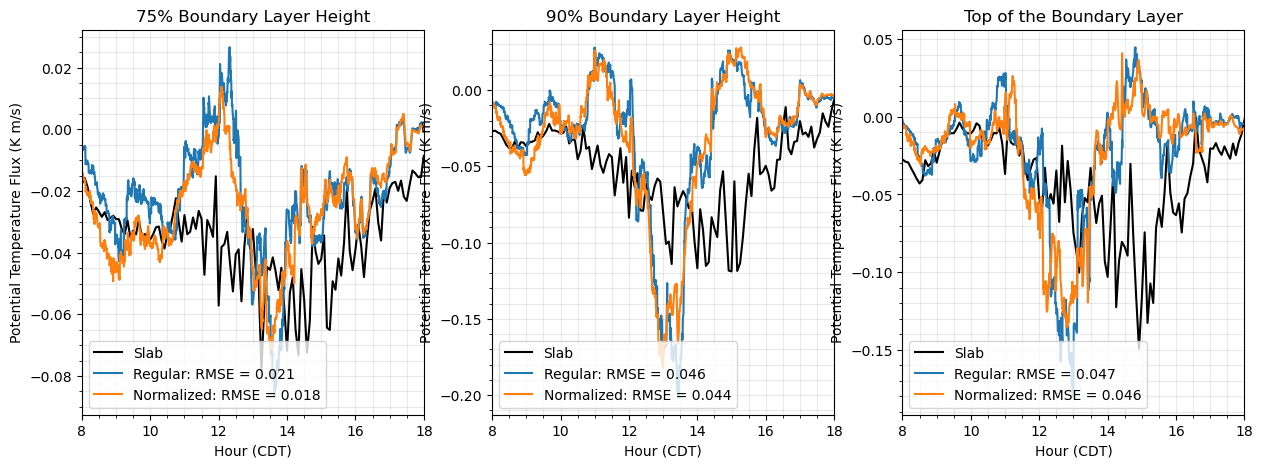

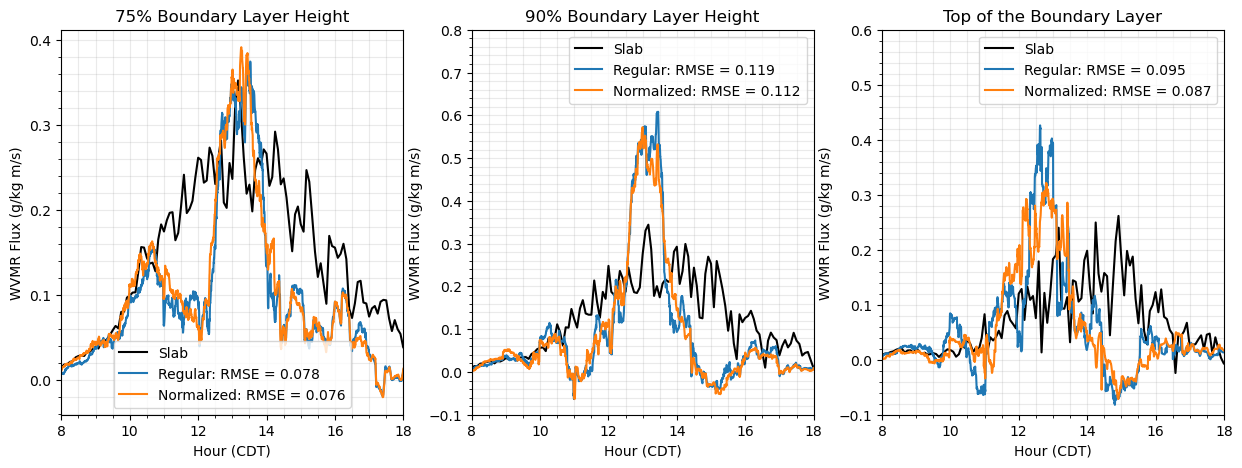

In [69]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, thlflux[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_fluxreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(thl_fluxregrmsezi75,3).values))
plt.plot(time, thl_fluxnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(thl_fluxnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Flux (K m/s)')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, thlflux[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_fluxreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(thl_fluxregrmsezi,3).values))
plt.plot(time, thl_fluxnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(thl_fluxnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Flux (K m/s)')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, thlflux[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_fluxreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(thl_fluxregrmse,3).values))
plt.plot(time, thl_fluxnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(thl_fluxnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Flux (K m/s)')
plt.title('Top of the Boundary Layer')
plt.legend()



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, qtflux[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_fluxreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(qt_fluxregrmsezi75,3).values))
plt.plot(time, qt_fluxnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(qt_fluxnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Flux (g/kg m/s)')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, qtflux[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_fluxreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(qt_fluxregrmsezi,3).values))
plt.plot(time, qt_fluxnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(qt_fluxnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.ylim(-0.1,0.8)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Flux (g/kg m/s)')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, qtflux[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_fluxreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(qt_fluxregrmse,3).values))
plt.plot(time, qt_fluxnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(qt_fluxnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.ylim(-0.1,0.6)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Flux (g/kg m/s)')
plt.title('Top of the Boundary Layer')
plt.legend()
plt.savefig('/data/OneDrive/Tessa Rosenberger/methodologypaper/qt_flux_comparison.pdf')


Now variance

/tmp/ipykernel_368778/2910210169.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/2910210169.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/2910210169.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/2910210169.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed

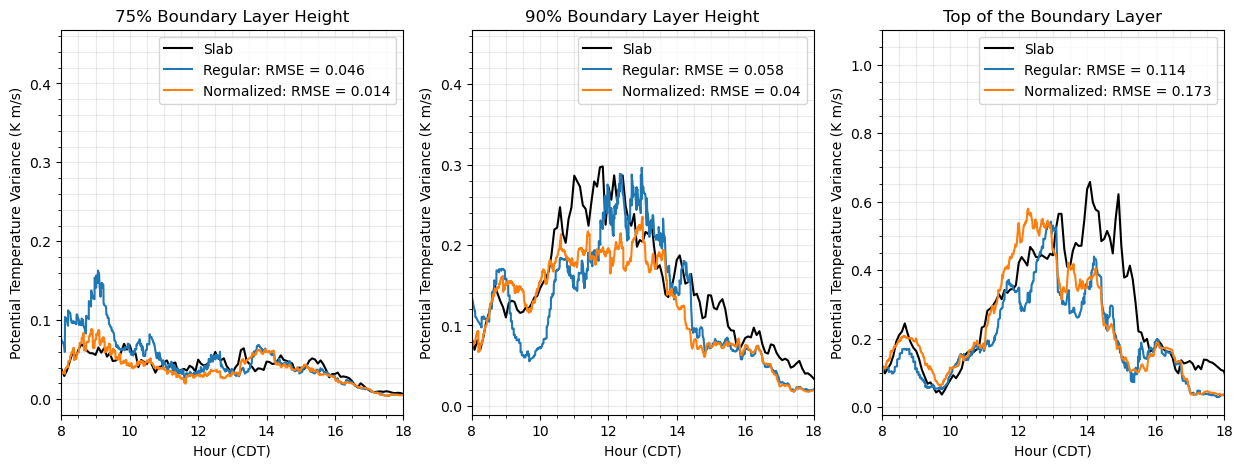

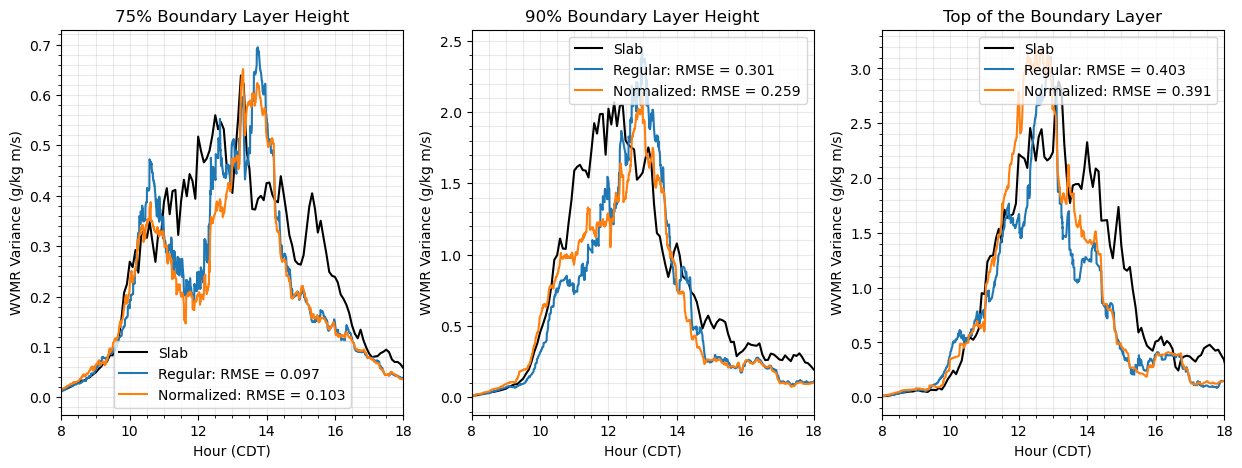

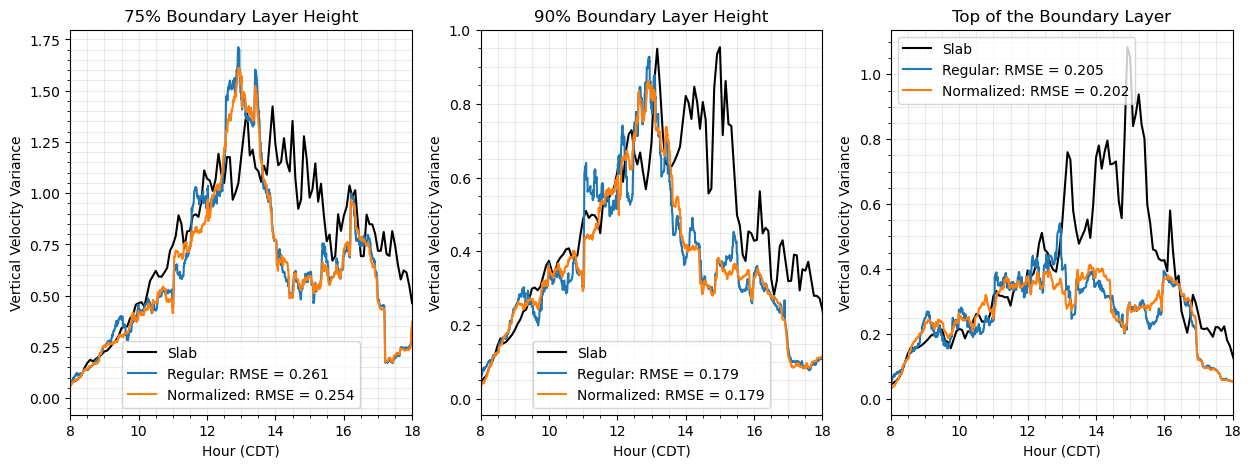

In [70]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, thl_var[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_varreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(thl_varregrmsezi75,3).values))
plt.plot(time, thl_varnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(thl_varnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Variance (K m/s)')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, thl_var[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_varreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(thl_varregrmsezi,3).values))
plt.plot(time, thl_varnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(thl_varnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Variance (K m/s)')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, thl_var[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_varreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(thl_varregrmse,3).values))
plt.plot(time, thl_varnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(thl_varnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Variance (K m/s)')
plt.title('Top of the Boundary Layer')
plt.legend()



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, qt_var[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_varreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(qt_varregrmsezi75,3).values))
plt.plot(time, qt_varnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(qt_varnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Variance (g/kg m/s)')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, qt_var[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_varreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(qt_varregrmsezi,3).values))
plt.plot(time, qt_varnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(qt_varnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
#plt.ylim(-0.1,0.8)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Variance (g/kg m/s)')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, qt_var[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_varreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(qt_varregrmse,3).values))
plt.plot(time, qt_varnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(qt_varnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
#plt.ylim(-0.1,0.6)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Variance (g/kg m/s)')
plt.title('Top of the Boundary Layer')
plt.legend()


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, w_var[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(w_varregrmsezi75,3).values))
plt.plot(time, w_varnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Variance')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, w_var[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(w_varregrmsezi,3).values))
plt.plot(time, w_varnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
#plt.ylim(-0.1,0.8)
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Variance')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, w_var[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(w_varregrmse,3).values))
plt.plot(time, w_varnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
#plt.ylim(-0.1,0.6)
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Variance')
plt.title('Top of the Boundary Layer')
plt.legend()

Skewness

/tmp/ipykernel_368778/1138631961.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/1138631961.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/1138631961.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/1138631961.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed

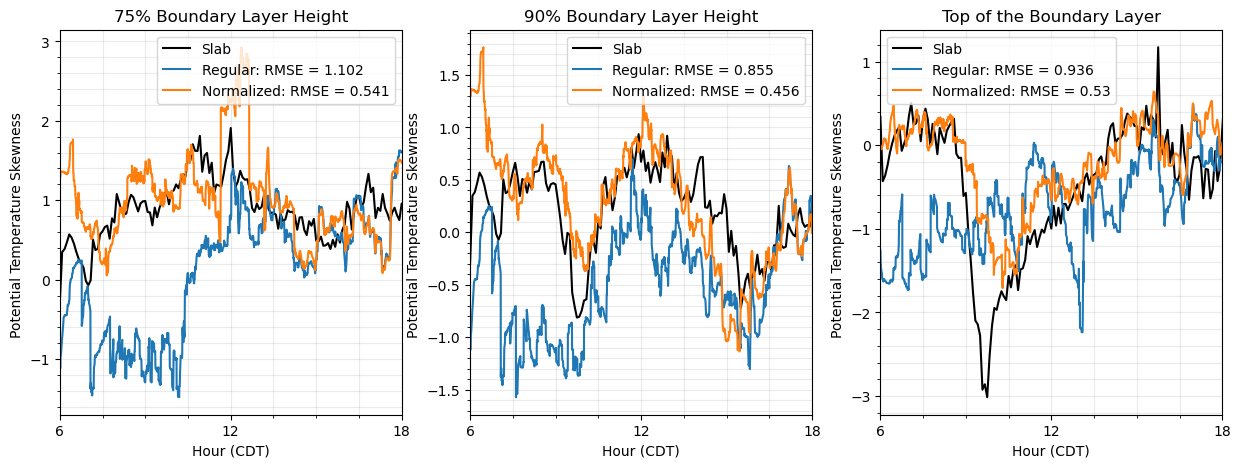

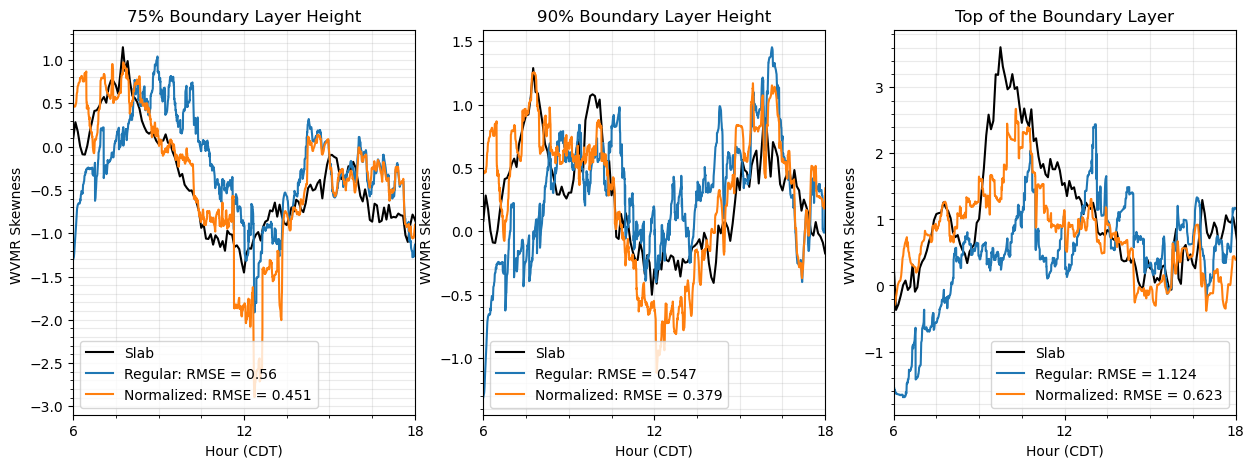

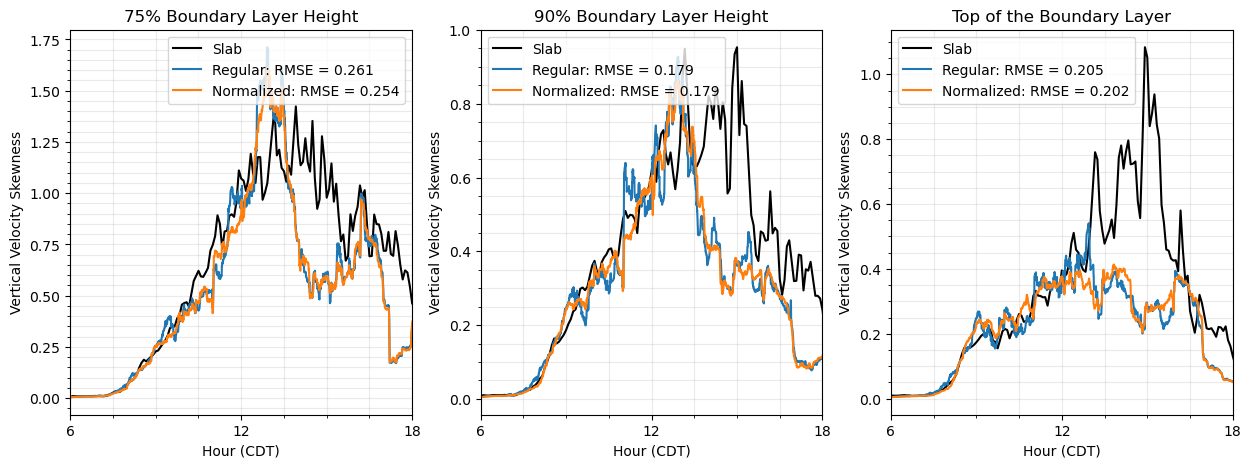

In [71]:

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, thl_skew[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_skewreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(thl_skewregrmsezi75,3).values))
plt.plot(time, thl_skewnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(thl_skewnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Skewness ')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, thl_skew[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_skewreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(thl_skewregrmsezi,3).values))
plt.plot(time, thl_skewnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(thl_skewnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Skewness ')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, thl_skew[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_skewreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(thl_skewregrmse,3).values))
plt.plot(time, thl_skewnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(thl_skewnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Skewness ')
plt.title('Top of the Boundary Layer')
plt.legend()



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, qt_skew[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_skewreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(qt_skewregrmsezi75,3).values))
plt.plot(time, qt_skewnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(qt_skewnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Skewness ')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, qt_skew[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_skewreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(qt_skewregrmsezi,3).values))
plt.plot(time, qt_skewnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(qt_skewnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.8)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Skewness ')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, qt_skew[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_skewreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(qt_skewregrmse,3).values))
plt.plot(time, qt_skewnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(qt_skewnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.6)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Skewness ')
plt.title('Top of the Boundary Layer')
plt.legend()


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, w_var[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(w_varregrmsezi75,3).values))
plt.plot(time, w_varnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Skewness')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, w_var[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(w_varregrmsezi,3).values))
plt.plot(time, w_varnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.8)
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Skewness')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, w_var[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(w_varregrmse,3).values))
plt.plot(time, w_varnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.6)
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Skewness')
plt.title('Top of the Boundary Layer')
plt.legend()


Kurtosis

/tmp/ipykernel_368778/2705704866.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/2705704866.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/2705704866.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
/tmp/ipykernel_368778/2705704866.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed

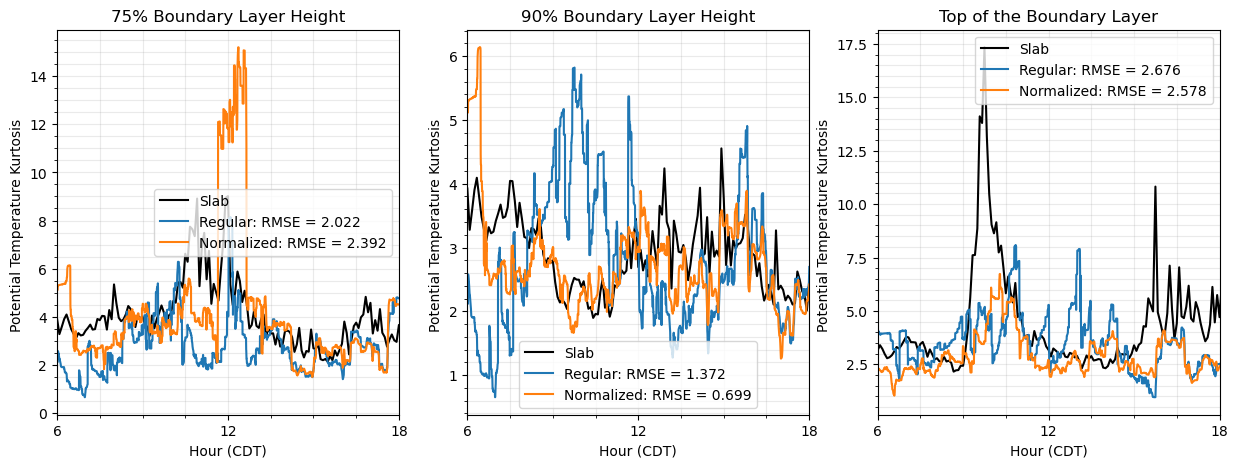

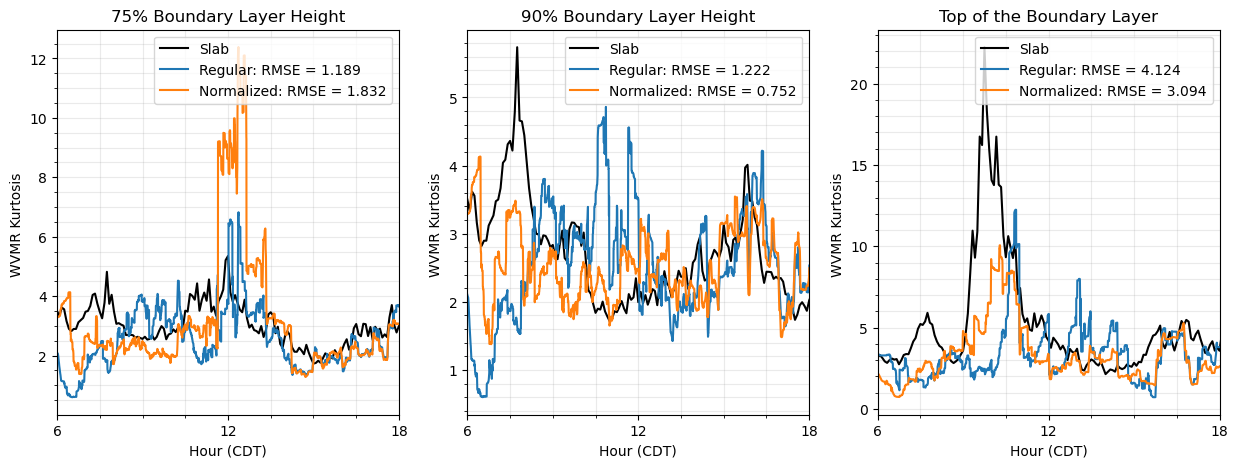

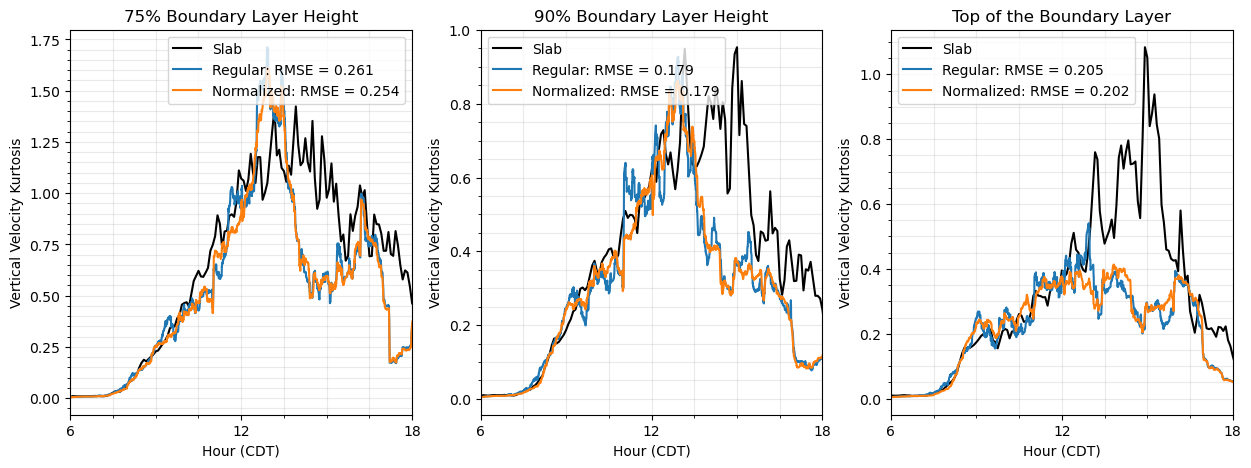

In [72]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, thl_kurt[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_kurtreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(thl_kurtregrmsezi75,3).values))
plt.plot(time, thl_kurtnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(thl_kurtnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Kurtosis ')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, thl_kurt[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_kurtreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(thl_kurtregrmsezi,3).values))
plt.plot(time, thl_kurtnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(thl_kurtnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Kurtosis ')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, thl_kurt[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, thl_kurtreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(thl_kurtregrmse,3).values))
plt.plot(time, thl_kurtnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(thl_kurtnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Potential Temperature Kurtosis ')
plt.title('Top of the Boundary Layer')
plt.legend()



plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, qt_kurt[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_kurtreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(qt_kurtregrmsezi75,3).values))
plt.plot(time, qt_kurtnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(qt_kurtnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Kurtosis ')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, qt_kurt[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_kurtreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(qt_kurtregrmsezi,3).values))
plt.plot(time, qt_kurtnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(qt_kurtnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.8)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Kurtosis ')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, qt_kurt[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, qt_kurtreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(qt_kurtregrmse,3).values))
plt.plot(time, qt_kurtnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(qt_kurtnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.6)
plt.xlabel('Hour (CDT)')
plt.ylabel('WVMR Kurtosis ')
plt.title('Top of the Boundary Layer')
plt.legend()


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(time_slab, w_var[start_slab:end_slab,ki75_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,ki75], label = 'Regular: RMSE = ' + str(np.round(w_varregrmsezi75,3).values))
plt.plot(time, w_varnorm[start:end,ki75], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmsezi75,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Kurtosis')
plt.title('75% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,2)
plt.plot(time_slab, w_var[start_slab:end_slab,ki90_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,ki90], label = 'Regular: RMSE = ' + str(np.round(w_varregrmsezi,3).values))
plt.plot(time, w_varnorm[start:end,ki90], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmsezi,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.8)
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Kurtosis')
plt.title('90% Boundary Layer Height')
plt.legend()   
plt.subplot(1,3,3)
plt.plot(time_slab, w_var[start_slab:end_slab,kiK_slab], label = 'Slab', color = 'black')
plt.plot(time, w_varreg[start:end,kiKsmooth], label = 'Regular: RMSE = ' + str(np.round(w_varregrmse,3).values))
plt.plot(time, w_varnorm[start:end,kiKsmooth], label = 'Normalized: RMSE = ' + str(np.round(w_varnormrmse,3).values))
plt.minorticks_on()
plt.grid(b='visible', which='major', color='#999999', linestyle='-', alpha=0.2)
plt.grid(b='visible', which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(8,18)
plt.xticks([6, 12, 18])
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.ylim(-0.1,0.6)
plt.xlabel('Hour (CDT)')
plt.ylabel('Vertical Velocity Kurtosis')
plt.title('Top of the Boundary Layer')
plt.legend()

# Now, we are going to compare these results across multiple dates by averaging over the five case dates

In [73]:
# Boundary layer depth definition without limits

def bldepth(thl):
    delta = 0.5*cp
    ki = (thl>delta+np.tile(thl[:,:1],[1,thl.shape[1]])).argmax(axis=1)
    return ki


 Bring in each date and find the average RMSE of each method and then average that over all of the dates 


In [74]:

aug7 = '/data/lafe/20170807/through_evening/'
aug14 = '/data/lafe/20170814/through_evening/'
aug17 = '/data/lafe/20170817/through_evening/'
aug29 = '/data/lafe/20170829/through_evening/'

In [75]:
list_of_dir = [aug7, dir, aug14, aug17, aug29]
qt_2regzi = np.zeros(len(list_of_dir))
qt_2normzi = np.zeros(len(list_of_dir))
qt_3regzi = np.zeros(len(list_of_dir))
qt_3normzi = np.zeros(len(list_of_dir))
qt_4regzi = np.zeros(len(list_of_dir))
qt_4normzi = np.zeros(len(list_of_dir))
thl_2regzi = np.zeros(len(list_of_dir))
thl_2normzi = np.zeros(len(list_of_dir))
thl_3regzi = np.zeros(len(list_of_dir))
thl_3normzi = np.zeros(len(list_of_dir))
thl_4regzi = np.zeros(len(list_of_dir))
thl_4normzi = np.zeros(len(list_of_dir))
w_2regzi = np.zeros(len(list_of_dir))
w_2normzi = np.zeros(len(list_of_dir))
w_3regzi = np.zeros(len(list_of_dir))
w_3normzi = np.zeros(len(list_of_dir))
w_4regzi = np.zeros(len(list_of_dir))
w_4normzi = np.zeros(len(list_of_dir))
thl_fluxregzi = np.zeros(len(list_of_dir))
thl_fluxnormzi = np.zeros(len(list_of_dir))
qt_fluxregzi = np.zeros(len(list_of_dir))
qt_fluxnormzi = np.zeros(len(list_of_dir))
qt_2reg75= np.zeros(len(list_of_dir))
qt_2norm75= np.zeros(len(list_of_dir))
qt_3reg75= np.zeros(len(list_of_dir))
qt_3norm75= np.zeros(len(list_of_dir))
qt_4reg75= np.zeros(len(list_of_dir))
qt_4norm75= np.zeros(len(list_of_dir))
thl_2reg75= np.zeros(len(list_of_dir))
thl_2norm75= np.zeros(len(list_of_dir))
thl_3reg75= np.zeros(len(list_of_dir))
thl_3norm75= np.zeros(len(list_of_dir))
thl_4reg75= np.zeros(len(list_of_dir))
thl_4norm75= np.zeros(len(list_of_dir))
w_2reg75= np.zeros(len(list_of_dir))
w_2norm75= np.zeros(len(list_of_dir))
w_3reg75= np.zeros(len(list_of_dir))
w_3norm75= np.zeros(len(list_of_dir))
w_4reg75= np.zeros(len(list_of_dir))
w_4norm75= np.zeros(len(list_of_dir))
thl_fluxreg75= np.zeros(len(list_of_dir))
thl_fluxnorm75= np.zeros(len(list_of_dir))
qt_fluxreg75= np.zeros(len(list_of_dir))
qt_fluxnorm75= np.zeros(len(list_of_dir))
qt_2reg90 = np.zeros(len(list_of_dir))
qt_2norm90 = np.zeros(len(list_of_dir))
qt_3reg90 = np.zeros(len(list_of_dir))
qt_3norm90 = np.zeros(len(list_of_dir))
qt_4reg90 = np.zeros(len(list_of_dir))
qt_4norm90 = np.zeros(len(list_of_dir))
thl_2reg90 = np.zeros(len(list_of_dir))
thl_2norm90 = np.zeros(len(list_of_dir))
thl_3reg90 = np.zeros(len(list_of_dir))
thl_3norm90 = np.zeros(len(list_of_dir))
thl_4reg90 = np.zeros(len(list_of_dir))
thl_4norm90 = np.zeros(len(list_of_dir))
w_2reg90 = np.zeros(len(list_of_dir))
w_2norm90 = np.zeros(len(list_of_dir))
w_3reg90 = np.zeros(len(list_of_dir))
w_3norm90 = np.zeros(len(list_of_dir))
w_4reg90 = np.zeros(len(list_of_dir))
w_4norm90 = np.zeros(len(list_of_dir))
thl_fluxreg90 = np.zeros(len(list_of_dir))
thl_fluxnorm90 = np.zeros(len(list_of_dir))
qt_fluxreg90 = np.zeros(len(list_of_dir))
qt_fluxnorm90 = np.zeros(len(list_of_dir))
for j in range(len(list_of_dir)):
    prof_all = xr.open_dataset(list_of_dir[j] + 'merged_prof_from_all_columns.nc', decode_times=False)
    time = prof_all['time']
    time = xr.DataArray(time, coords={'time':time}, dims=['time'])
    dt = time.diff('time')[0].to_numpy()
    colx = 4
    coly = 4
    wh = prof_all['w'][colx,coly,:,:] #w velocity defined at zh
    w = wh.interp(time = time, zh = z) #take the vertical velocity at z instead of zh
    filenames_slab = 'testbed.default.0000000.nc'
    groups_slab = [''] + list(nc.Dataset(list_of_dir[j] + filenames_slab).groups.keys())
    prof_dict_slab = {}
    for group in groups_slab:
        prof_dict_slab[group] = xr.open_dataset(list_of_dir[j] + filenames_slab, group=group, decode_times=False)
    prof_slab = xr.merge(prof_dict_slab.values(), compat = 'override')
    time_slab = prof_slab['time']
    dt_slab = time_slab.diff('time')[0].to_numpy()
    sr_slab = int((abs(time_slab - start)).argmin())
    ss_slab = int((abs(time_slab - end)).argmin())
    rho = prof_slab['rho']
    rhoh = prof_slab['rhoh']
    corr = rho/rho[0,0]
    corrh = rhoh/rhoh[0,0]
    z = prof_slab['z']
    zh = prof_slab['zh']
    thl = prof_all['thl'][colx,coly,:,:] #single column potential temperature
    qt = prof_all['qt'][colx,coly,:,:]*1000 #single column water vapor mixing ratio
    thl_slab = prof_slab['thl']
    kiK = bldepth(thl)
    kiK_slab = bldepth(thl_slab)
    ziK = zh[kiK]
    ziK_slab = zh[kiK_slab]
    kiKsmooth = np.round(savgol_filter(kiK, one_window, order))
    kiKsmooth = np.maximum(kiKsmooth, 0).astype(int)
    kiKsmooth = xr.DataArray(kiKsmooth, coords={'time':time}, dims=['time'])
    zismooth = zh[kiKsmooth]
    qt_var =prof_slab['qt_2']*(1000**2) 
    thl_var = prof_slab['thl_2']
    thl_skew = prof_slab['thl_3']/(prof_slab['thl_2']**(3/2))
    qt_skew = prof_slab['qt_3']/(prof_slab['qt_2']**(3/2))
    thlflux = prof_slab['thl_flux']
    qtflux = prof_slab['qt_flux']*(1000)
    w_var = prof_slab['w_2'].interp(time = time_slab, zh = z)
    w_skew = (prof_slab['w_3'].interp(time=time_slab,zh=z))/((prof_slab['w_2'].interp(time = time_slab, zh=z))**(3/2))
    thl_kurt = prof_slab['thl_4']/(prof_slab['thl_2']**2)
    qt_kurt = prof_slab['qt_4']/(prof_slab['qt_2']**2)
    w_kurt = prof_slab['w_4'].interp(time = time_slab, zh = z)/(prof_slab['w_2'].interp(time = time_slab, zh = z)**2)
    z_da = xr.DataArray(z, dims='z')
    zism_da = xr.DataArray(zism, dims='time')
    znorm = z_da / zism_da
    znorm = znorm.T
    # make qt_norm and thl_norm by interpolating qt and thl onto znorm
    qt_norm = np.empty((time.size, z.size))
    thl_norm = np.empty((time.size, z.size))
    w_norm = np.empty((time.size, z.size))
    for i in range(time.size):
        qt_norm[i,:] = np.interp(z, znorm[i,:], qt[i,:])
        thl_norm[i,:] = np.interp(z, znorm[i,:], thl[i,:])
        w_norm[i,:] = np.interp(z, znorm[i,:], w[i,:])
    thl_varnormnorm = variance(thl_norm, one_window)
    qt_varnormnorm = variance(qt_norm, one_window)
    thl_skewnormnorm = skewness(thl_norm, one_window)
    qt_skewnormnorm = skewness(qt_norm, one_window)
    thl_flunormnorm = flux(thl_norm, w_norm, one_window)
    qt_flunormnorm = flux(qt_norm, w_norm, one_window)
    w_varnormnorm = variance(w_norm, one_window)
    w_skewnormnorm = skewness(w_norm, one_window)
    thl_kurtnormnorm = kurtosis(thl_norm, one_window)
    qt_kurtnormnorm = kurtosis(qt_norm, one_window)
    w_kurtnormnorm = kurtosis(w_norm, one_window)
    # interpolate the normalized variance and skewness onto the regular grid
    thl_varnorm = np.empty((time.size, z.size))
    qt_varnorm = np.empty((time.size, z.size))
    thl_skewnorm = np.empty((time.size, z.size))
    qt_skewnorm = np.empty((time.size, z.size))
    thl_fluxnorm = np.empty((time.size, z.size))
    qt_fluxnorm = np.empty((time.size, z.size))
    w_varnorm = np.empty((time.size, z.size))
    w_skewnorm = np.empty((time.size, z.size))
    thl_kurtnorm = np.empty((time.size, z.size))
    qt_kurtnorm = np.empty((time.size, z.size))
    w_kurtnorm = np.empty((time.size, z.size))
    for i in range(time.size):
        thl_varnorm[i,:] = np.interp(znorm[i,:],z, thl_varnormnorm[i,:])
        qt_varnorm[i,:] = np.interp(znorm[i,:],z, qt_varnormnorm[i,:])
        thl_skewnorm[i,:] = np.interp( znorm[i,:], z,thl_skewnormnorm[i,:])
        qt_skewnorm[i,:] = np.interp(znorm[i,:],z, qt_skewnormnorm[i,:])
        thl_fluxnorm[i,:] = np.interp(znorm[i,:],z, thl_flunormnorm[i,:])
        qt_fluxnorm[i,:] = np.interp(znorm[i,:],z, qt_flunormnorm[i,:])
        w_varnorm[i,:] = np.interp(znorm[i,:],z, w_varnormnorm[i,:])
        w_skewnorm[i,:] = np.interp(znorm[i,:],z, w_skewnormnorm[i,:])
        thl_kurtnorm[i,:] = np.interp(znorm[i,:],z, thl_kurtnormnorm[i,:])
        qt_kurtnorm[i,:] = np.interp(znorm[i,:],z, qt_kurtnormnorm[i,:])
        w_kurtnorm[i,:] = np.interp(znorm[i,:],z, w_kurtnormnorm[i,:])
    thl_varreg = variance(thl, one_window)
    qt_varreg = variance(qt, one_window)
    thl_skewreg = skewness(thl, one_window)
    qt_skewreg = skewness(qt, one_window)
    thl_fluxreg = flux(thl, w, one_window)
    qt_fluxreg = flux(qt, w, one_window)
    w_varreg = variance(w, one_window)
    w_skewreg = skewness(w, one_window)
    thl_kurtreg = kurtosis(thl, one_window)
    qt_kurtreg = kurtosis(qt, one_window)
    w_kurtreg = kurtosis(w, one_window)
    start = 1080
    end = 5760
    start_slab = 36
    end_slab = 192
    # plot line plots of the slab, regular, and normalized fluxes, variances, and skewnesses at the top of the boundary layer over time
    thl_fluxreg = xr.DataArray(thl_fluxreg, dims=thl.dims, coords=thl.coords)
    qt_fluxreg = xr.DataArray(qt_fluxreg, dims=qt.dims, coords=qt.coords)
    thl_fluxnorm = xr.DataArray(thl_fluxnorm, dims=thl.dims, coords=thl.coords)
    qt_fluxnorm = xr.DataArray(qt_fluxnorm, dims=qt.dims, coords=qt.coords)
    thl_varreg = xr.DataArray(thl_varreg, dims=thl.dims, coords=thl.coords)
    qt_varreg = xr.DataArray(qt_varreg, dims=qt.dims, coords=qt.coords)
    thl_varnorm = xr.DataArray(thl_varnorm, dims=thl.dims, coords=thl.coords)
    qt_varnorm = xr.DataArray(qt_varnorm, dims=qt.dims, coords=qt.coords)
    thl_skewreg = xr.DataArray(thl_skewreg, dims=thl.dims, coords=thl.coords)
    qt_skewreg = xr.DataArray(qt_skewreg, dims=qt.dims, coords=qt.coords)
    thl_skewnorm = xr.DataArray(thl_skewnorm, dims=thl.dims, coords=thl.coords)
    qt_skewnorm = xr.DataArray(qt_skewnorm, dims=qt.dims, coords=qt.coords)
    w_varnorm = xr.DataArray(w_varnorm, dims=w.dims, coords=w.coords)
    w_skewnorm = xr.DataArray(w_skewnorm, dims=w.dims, coords=w.coords)
    w_varreg = xr.DataArray(w_varreg, dims=w.dims, coords=w.coords)
    w_skewreg = xr.DataArray(w_skewreg, dims=w.dims, coords=w.coords)
    thl_kurtreg = xr.DataArray(thl_kurtreg, dims=thl.dims, coords=thl.coords)
    qt_kurtreg = xr.DataArray(qt_kurtreg, dims=qt.dims, coords=qt.coords)
    w_kurtreg = xr.DataArray(w_kurtreg, dims=w.dims, coords=w.coords)
    thl_kurtnorm = xr.DataArray(thl_kurtnorm, dims=thl.dims, coords=thl.coords)
    qt_kurtnorm = xr.DataArray(qt_kurtnorm, dims=qt.dims, coords=qt.coords)
    w_kurtnorm = xr.DataArray(w_kurtnorm, dims=w.dims, coords=w.coords)
    kiKsmooth = kiKsmooth[start:end]
    kiK_slab = kiK_slab[start_slab:end_slab]
    ki90 = (kiKsmooth*0.9).astype(int)
    ki90_slab = (kiK_slab*0.9).astype(int)
    ki75 = (kiKsmooth*0.75).astype(int)
    ki75_slab = (kiK_slab*0.75).astype(int)
    # calculate the RMSE of each variable and its corresponding slab
    thl_fluxregzi[j] = np.sqrt(((thl_fluxreg[start:end,kiKsmooth] - thlflux[start_slab:end_slab,kiK_slab])**2).mean())
    qt_fluxregzi[j] = np.sqrt(((qt_fluxreg[start:end,kiKsmooth] - qtflux[start_slab:end_slab,kiK_slab])**2).mean())
    thl_fluxnormzi[j] = np.sqrt(((thl_fluxnorm[start:end,kiKsmooth] - thlflux[start_slab:end_slab,kiK_slab])**2).mean())
    qt_fluxnormzi[j] = np.sqrt(((qt_fluxnorm[start:end,kiKsmooth] - qtflux[start_slab:end_slab,kiK_slab])**2).mean())
    qt_2regzi[j] = np.sqrt(((qt_varreg[start:end,kiKsmooth] - qt_var[start_slab:end_slab,kiK_slab])**2).mean())
    qt_2normzi[j] = np.sqrt(((qt_varnorm[start:end,kiKsmooth] - qt_var[start_slab:end_slab,kiK_slab])**2).mean())
    qt_3regzi[j] = np.sqrt(((qt_skewreg[start:end,kiKsmooth] - qt_skew[start_slab:end_slab,kiK_slab])**2).mean())
    qt_3normzi[j] = np.sqrt(((qt_skewnorm[start:end,kiKsmooth] - qt_skew[start_slab:end_slab,kiK_slab])**2).mean())
    qt_4regzi[j] = np.sqrt(((qt_kurtreg[start:end,kiKsmooth] - qt_kurt[start_slab:end_slab,kiK_slab])**2).mean())
    qt_4normzi[j] = np.sqrt(((qt_kurtnorm[start:end,kiKsmooth] - qt_kurt[start_slab:end_slab,kiK_slab])**2).mean())
    w_2regzi[j] = np.sqrt(((w_varreg[start:end,kiKsmooth] - w_var[start_slab:end_slab,kiK_slab])**2).mean())
    w_2normzi[j] = np.sqrt(((w_varnorm[start:end,kiKsmooth] - w_var[start_slab:end_slab,kiK_slab])**2).mean())
    w_3regzi[j] = np.sqrt(((w_skewreg[start:end,kiKsmooth] - w_skew[start_slab:end_slab,kiK_slab])**2).mean())
    w_3normzi[j] = np.sqrt(((w_skewnorm[start:end,kiKsmooth] - w_skew[start_slab:end_slab,kiK_slab])**2).mean())
    w_4regzi[j] = np.sqrt(((w_kurtreg[start:end,kiKsmooth] - w_kurt[start_slab:end_slab,kiK_slab])**2).mean())
    w_4normzi[j] = np.sqrt(((w_kurtnorm[start:end,kiKsmooth] - w_kurt[start_slab:end_slab,kiK_slab])**2).mean())
    thl_2regzi[j] = np.sqrt(((thl_varreg[start:end,kiKsmooth] - thl_var[start_slab:end_slab,kiK_slab])**2).mean())
    thl_2normzi[j] = np.sqrt(((thl_varnorm[start:end,kiKsmooth] - thl_var[start_slab:end_slab,kiK_slab])**2).mean())
    thl_3regzi[j] = np.sqrt(((thl_skewreg[start:end,kiKsmooth] - thl_skew[start_slab:end_slab,kiK_slab])**2).mean())
    thl_3normzi[j] = np.sqrt(((thl_skewnorm[start:end,kiKsmooth] - thl_skew[start_slab:end_slab,kiK_slab])**2).mean())
    thl_4regzi[j] = np.sqrt(((thl_kurtreg[start:end,kiKsmooth] - thl_kurt[start_slab:end_slab,kiK_slab])**2).mean())
    thl_4normzi[j] = np.sqrt(((thl_kurtnorm[start:end,kiKsmooth] - thl_kurt[start_slab:end_slab,kiK_slab])**2).mean())
    qt_fluxreg75[j] = np.sqrt(((qt_fluxreg[start:end,ki75] - qtflux[start_slab:end_slab,ki75_slab])**2).mean())
    thl_fluxreg75[j] = np.sqrt(((thl_fluxreg[start:end,ki75] - thlflux[start_slab:end_slab,ki75_slab])**2).mean())
    qt_fluxnorm75[j] = np.sqrt(((qt_fluxnorm[start:end,ki75] - qtflux[start_slab:end_slab,ki75_slab])**2).mean())
    thl_fluxnorm75[j] = np.sqrt(((thl_fluxnorm[start:end,ki75] - thlflux[start_slab:end_slab,ki75_slab])**2).mean())
    qt_2reg75[j] = np.sqrt(((qt_varreg[start:end,ki75] - qt_var[start_slab:end_slab,ki75_slab])**2).mean())
    qt_2norm75[j] = np.sqrt(((qt_varnorm[start:end,ki75] - qt_var[start_slab:end_slab,ki75_slab])**2).mean())
    qt_3reg75[j] = np.sqrt(((qt_skewreg[start:end,ki75] - qt_skew[start_slab:end_slab,ki75_slab])**2).mean())
    qt_3norm75[j] = np.sqrt(((qt_skewnorm[start:end,ki75] - qt_skew[start_slab:end_slab,ki75_slab])**2).mean())
    qt_4reg75[j] = np.sqrt(((qt_kurtreg[start:end,ki75] - qt_kurt[start_slab:end_slab,ki75_slab])**2).mean())
    qt_4norm75[j] = np.sqrt(((qt_kurtnorm[start:end,ki75] - qt_kurt[start_slab:end_slab,ki75_slab])**2).mean())
    w_2reg75[j] = np.sqrt(((w_varreg[start:end,ki75] - w_var[start_slab:end_slab,ki75_slab])**2).mean())
    w_2norm75[j] = np.sqrt(((w_varnorm[start:end,ki75] - w_var[start_slab:end_slab,ki75_slab])**2).mean())
    w_3reg75[j] = np.sqrt(((w_skewreg[start:end,ki75] - w_skew[start_slab:end_slab,ki75_slab])**2).mean())
    w_3norm75[j] = np.sqrt(((w_skewnorm[start:end,ki75] - w_skew[start_slab:end_slab,ki75_slab])**2).mean())
    w_4reg75[j] = np.sqrt(((w_kurtreg[start:end,ki75] - w_kurt[start_slab:end_slab,ki75_slab])**2).mean())
    w_4norm75[j] = np.sqrt(((w_kurtnorm[start:end,ki75] - w_kurt[start_slab:end_slab,ki75_slab])**2).mean())
    thl_2reg75[j] = np.sqrt(((thl_varreg[start:end,ki75] - thl_var[start_slab:end_slab,ki75_slab])**2).mean())
    thl_2norm75[j] = np.sqrt(((thl_varnorm[start:end,ki75] - thl_var[start_slab:end_slab,ki75_slab])**2).mean())
    thl_3reg75[j] = np.sqrt(((thl_skewreg[start:end,ki75] - thl_skew[start_slab:end_slab,ki75_slab])**2).mean())
    thl_3norm75[j] = np.sqrt(((thl_skewnorm[start:end,ki75] - thl_skew[start_slab:end_slab,ki75_slab])**2).mean())
    thl_4reg75[j] = np.sqrt(((thl_kurtreg[start:end,ki75] - thl_kurt[start_slab:end_slab,ki75_slab])**2).mean())
    thl_4norm75[j] = np.sqrt(((thl_kurtnorm[start:end,ki75] - thl_kurt[start_slab:end_slab,ki75_slab])**2).mean())
    qt_2reg90[j] = np.sqrt(((qt_varreg[start:end,ki90] - qt_var[start_slab:end_slab,ki90_slab])**2).mean())
    qt_2norm90[j] = np.sqrt(((qt_varnorm[start:end,ki90] - qt_var[start_slab:end_slab,ki90_slab])**2).mean())
    qt_fluxreg90[j] = np.sqrt(((qt_fluxreg[start:end,ki90] - qtflux[start_slab:end_slab,ki90_slab])**2).mean())
    qt_fluxnorm90[j] = np.sqrt(((qt_fluxnorm[start:end,ki90] - qtflux[start_slab:end_slab,ki90_slab])**2).mean())
    thl_fluxreg90[j] = np.sqrt(((thl_fluxreg[start:end,ki90] - thlflux[start_slab:end_slab,ki90_slab])**2).mean())
    thl_fluxnorm90[j] = np.sqrt(((thl_fluxnorm[start:end,ki90] - thlflux[start_slab:end_slab,ki90_slab])**2).mean())
    qt_3reg90[j] = np.sqrt(((qt_skewreg[start:end,ki90] - qt_skew[start_slab:end_slab,ki90_slab])**2).mean())
    qt_3norm90[j] = np.sqrt(((qt_skewnorm[start:end,ki90] - qt_skew[start_slab:end_slab,ki90_slab])**2).mean())
    qt_4reg90[j] = np.sqrt(((qt_kurtreg[start:end,ki90] - qt_kurt[start_slab:end_slab,ki90_slab])**2).mean())
    qt_4norm90[j] = np.sqrt(((qt_kurtnorm[start:end,ki90] - qt_kurt[start_slab:end_slab,ki90_slab])**2).mean())
    w_2reg90[j] = np.sqrt(((w_varreg[start:end,ki90] - w_var[start_slab:end_slab,ki90_slab])**2).mean())
    w_2norm90[j] = np.sqrt(((w_varnorm[start:end,ki90] - w_var[start_slab:end_slab,ki90_slab])**2).mean())
    w_3reg90[j] = np.sqrt(((w_skewreg[start:end,ki90] - w_skew[start_slab:end_slab,ki90_slab])**2).mean())
    w_3norm90[j] = np.sqrt(((w_skewnorm[start:end,ki90] - w_skew[start_slab:end_slab,ki90_slab])**2).mean())
    w_4reg90[j] = np.sqrt(((w_kurtreg[start:end,ki90] - w_kurt[start_slab:end_slab,ki90_slab])**2).mean())
    w_4norm90[j] = np.sqrt(((w_kurtnorm[start:end,ki90] - w_kurt[start_slab:end_slab,ki90_slab])**2).mean())
    thl_2reg90[j] = np.sqrt(((thl_varreg[start:end,ki90] - thl_var[start_slab:end_slab,ki90_slab])**2).mean())
    thl_2norm90[j] = np.sqrt(((thl_varnorm[start:end,ki90] - thl_var[start_slab:end_slab,ki90_slab])**2).mean())
    thl_3reg90[j] = np.sqrt(((thl_skewreg[start:end,ki90] - thl_skew[start_slab:end_slab,ki90_slab])**2).mean())
    thl_3norm90[j] = np.sqrt(((thl_skewnorm[start:end,ki90] - thl_skew[start_slab:end_slab,ki90_slab])**2).mean())
    thl_4reg90[j] = np.sqrt(((thl_kurtreg[start:end,ki90] - thl_kurt[start_slab:end_slab,ki90_slab])**2).mean())
    thl_4norm90[j] = np.sqrt(((thl_kurtnorm[start:end,ki90] - thl_kurt[start_slab:end_slab,ki90_slab])**2).mean())



In [76]:

# find the mean across all five dates for each RMSE
thl_fluxregzi = thl_fluxregzi.mean()
qt_fluxregzi = qt_fluxregzi.mean()
thl_fluxnormzi = thl_fluxnormzi.mean()
qt_fluxnormzi = qt_fluxnormzi.mean()
qt_2regzi = qt_2regzi.mean()
qt_2normzi = qt_2normzi.mean()
qt_3regzi = qt_3regzi.mean()
qt_3normzi = qt_3normzi.mean()
qt_4regzi = qt_4regzi.mean()
qt_4normzi = qt_4normzi.mean()
w_2regzi = w_2regzi.mean()
w_2normzi = w_2normzi.mean()
w_3regzi = w_3regzi.mean()
w_3normzi = w_3normzi.mean()
w_4regzi = w_4regzi.mean()
w_4normzi = w_4normzi.mean()
thl_2regzi = thl_2regzi.mean()
thl_2normzi = thl_2normzi.mean()
thl_3regzi = thl_3regzi.mean()
thl_3normzi = thl_3normzi.mean()
thl_4regzi = thl_4regzi.mean()
thl_4normzi = thl_4normzi.mean()
qt_fluxreg75= qt_fluxreg75.mean()
thl_fluxreg75= thl_fluxreg75.mean()
qt_fluxnorm75= qt_fluxnorm75.mean()
thl_fluxnorm75= thl_fluxnorm75.mean()
qt_2reg75= qt_2reg75.mean()
qt_2norm75= qt_2norm75.mean()
qt_3reg75= qt_3reg75.mean()
qt_3norm75= qt_3norm75.mean()
qt_4reg75= qt_4reg75.mean()
qt_4norm75= qt_4norm75.mean()
w_2reg75= w_2reg75.mean()
w_2norm75= w_2norm75.mean()
w_3reg75= w_3reg75.mean()
w_3norm75= w_3norm75.mean()
w_4reg75= w_4reg75.mean()
w_4norm75= w_4norm75.mean()
thl_2reg75= thl_2reg75.mean()
thl_2norm75= thl_2norm75.mean()
thl_3reg75= thl_3reg75.mean()
thl_3norm75= thl_3norm75.mean()
thl_4reg75= thl_4reg75.mean()
thl_4norm75= thl_4norm75.mean()
qt_2reg90 = qt_2reg90.mean()
qt_2norm90 = qt_2norm90.mean()
qt_fluxreg90 = qt_fluxreg90.mean()
qt_fluxnorm90 = qt_fluxnorm90.mean()
thl_fluxreg90 = thl_fluxreg90.mean()
thl_fluxnorm90 = thl_fluxnorm90.mean()
qt_3reg90 = qt_3reg90.mean()
qt_3norm90 = qt_3norm90.mean()
qt_4reg90 = qt_4reg90.mean()
qt_4norm90 = qt_4norm90.mean()
w_2reg90 = w_2reg90.mean()
w_2norm90 = w_2norm90.mean()
w_3reg90 = w_3reg90.mean()
w_3norm90 = w_3norm90.mean()
w_4reg90 = w_4reg90.mean()
w_4norm90 = w_4norm90.mean()
thl_2reg90 = thl_2reg90.mean()
thl_2norm90 = thl_2norm90.mean()
thl_3reg90 = thl_3reg90.mean()
thl_3norm90 = thl_3norm90.mean()
thl_4reg90 = thl_4reg90.mean()
thl_4norm90 = thl_4norm90.mean()




In [77]:

# Define the data for the table
data = [
    ["Variable", "Regular", "Normalized"],
    ["Potential Temperature Flux at zi", thl_fluxregzi, thl_fluxnormzi],
    ["Water Vapor Mixing Ratio Flux at zi", qt_fluxregzi, qt_fluxnormzi],
    ["Water Vapor Mixing Ratio Variance at zi", qt_2regzi, qt_2normzi],
    ["Water Vapor Mixing Ratio Skewness at zi", qt_3regzi, qt_3normzi],
    ["Water Vapor Mixing Ratio Kurtosis at zi", qt_4regzi, qt_4normzi],
    ["Vertical Velocity Variance at zi", w_2regzi, w_2normzi],
    ["Vertical Velocity Skewness at zi", w_3regzi, w_3normzi],
    ["Vertical Velocity Kurtosis at zi", w_4regzi, w_4normzi],
    ["Potential Temperature Variance at zi", thl_2regzi, thl_2normzi],
    ["Potential Temperature Skewness at zi", thl_3regzi, thl_3normzi],
    ["Potential Temperature Kurtosis at zi", thl_4regzi, thl_4normzi],
    ["Water Vapor Mixing Ratio Flux at 75% zi", qt_fluxreg75, qt_fluxnorm75],
    ["Potential Temperature Flux at 75% zi", thl_fluxreg75, thl_fluxnorm75],
    ["Water Vapor Mixing Ratio Variance at 75% zi", qt_2reg75, qt_2norm75],
    ["Water Vapor Mixing Ratio Skewness at 75% zi", qt_3reg75, qt_3norm75],
    ["Water Vapor Mixing Ratio Kurtosis at 75% zi", qt_4reg75, qt_4norm75],
    ["Vertical Velocity Variance at 75% zi", w_2reg75, w_2norm75],
    ["Vertical Velocity Skewness at 75% zi", w_3reg75, w_3norm75],
    ["Vertical Velocity Kurtosis at 75% zi", w_4reg75, w_4norm75],
    ["Potential Temperature Variance at 75% zi", thl_2reg75, thl_2norm75],
    ["Potential Temperature Skewness at 75% zi", thl_3reg75, thl_3norm75],
    ["Potential Temperature Kurtosis at 75% zi", thl_4reg75, thl_4norm75],
    ["Water Vapor Mixing Ratio Flux at 90% zi", qt_fluxreg90, qt_fluxnorm90],
    ["Potential Temperature Flux at 90% zi", thl_fluxreg90, thl_fluxnorm90],
    ["Water Vapor Mixing Ratio Variance at 90% zi", qt_2reg90, qt_2norm90],
    ["Water Vapor Mixing Ratio Skewness at 90% zi", qt_3reg90, qt_3norm90],
    ["Water Vapor Mixing Ratio Kurtosis at 90% zi", qt_4reg90, qt_4norm90],
    ["Vertical Velocity Variance at 90% zi", w_2reg90, w_2norm90],
    ["Vertical Velocity Skewness at 90% zi", w_3reg90, w_3norm90],
    ["Vertical Velocity Kurtosis at 90% zi", w_4reg90, w_4norm90],
    ["Potential Temperature Variance at 90% zi", thl_2reg90, thl_2norm90],
    ["Potential Temperature Skewness at 90% zi", thl_3reg90, thl_3norm90],
    ["Potential Temperature Kurtosis at 90% zi", thl_4reg90, thl_4norm90]
]

# Create the table
table = tabulate(data, headers="firstrow", tablefmt="fancy_grid")

# Print the table
print(table)

╒═════════════════════════════════════════════╤════════════╤══════════════╕
│ Variable                                    │    Regular │   Normalized │
╞═════════════════════════════════════════════╪════════════╪══════════════╡
│ Potential Temperature Flux at zi            │  0.0402893 │    0.0412066 │
├─────────────────────────────────────────────┼────────────┼──────────────┤
│ Water Vapor Mixing Ratio Flux at zi         │  0.0782783 │    0.0793419 │
├─────────────────────────────────────────────┼────────────┼──────────────┤
│ Water Vapor Mixing Ratio Variance at zi     │  0.356196  │    0.355465  │
├─────────────────────────────────────────────┼────────────┼──────────────┤
│ Water Vapor Mixing Ratio Skewness at zi     │  1.16313   │    1.0559    │
├─────────────────────────────────────────────┼────────────┼──────────────┤
│ Water Vapor Mixing Ratio Kurtosis at zi     │ 13.4314    │   13.1286    │
├─────────────────────────────────────────────┼────────────┼──────────────┤
│ Vertical V